# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA

mkdir: cannot create directory ‘FIG’: File exists
mkdir: cannot create directory ‘FIG/FRAME’: File exists
mkdir: cannot create directory ‘WEIGHTS’: File exists
mkdir: cannot create directory ‘DATA’: File exists


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

(70000, 784)


## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('1', '4', '7')
dataset with 21994 points, each with 784 bits

first 10 MNIST data points


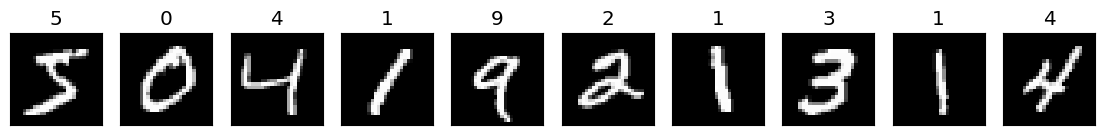

first 10 MNIST-3 data points


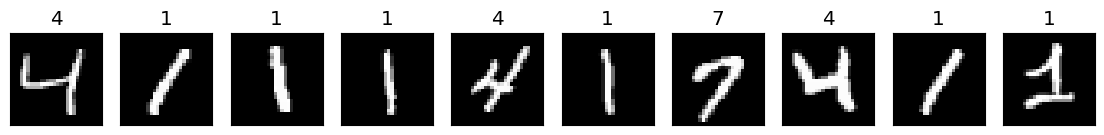

first 10 MNIST-3 data points, binarized


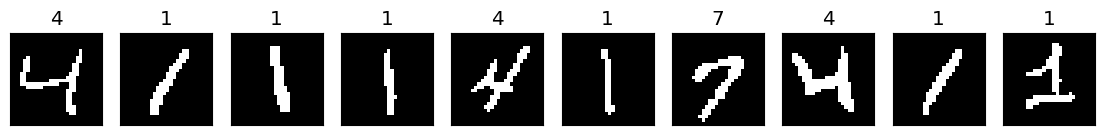

each of Nd=21994 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "gray"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[1:8:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

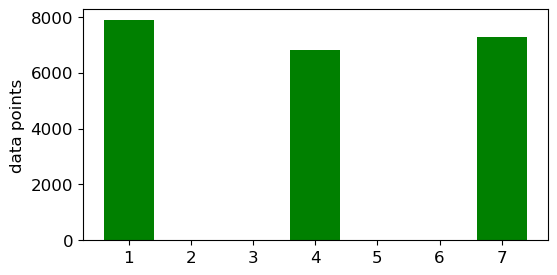

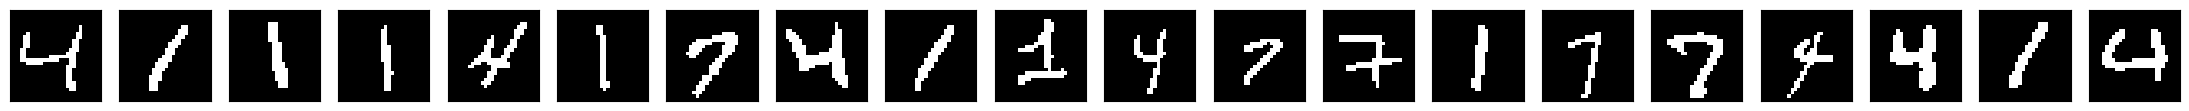

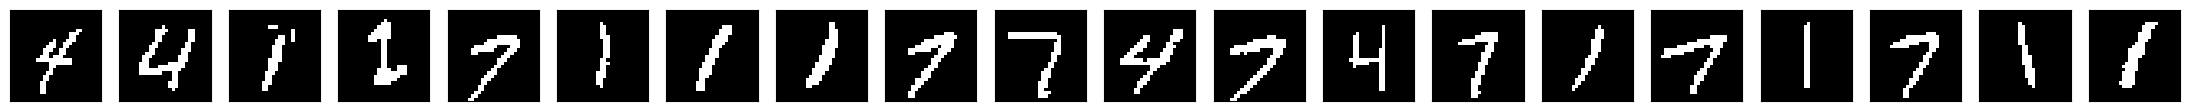

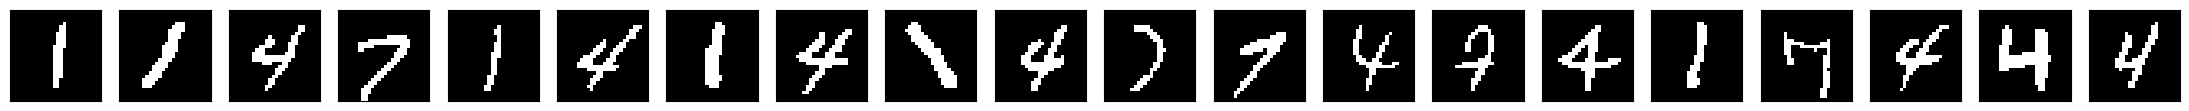

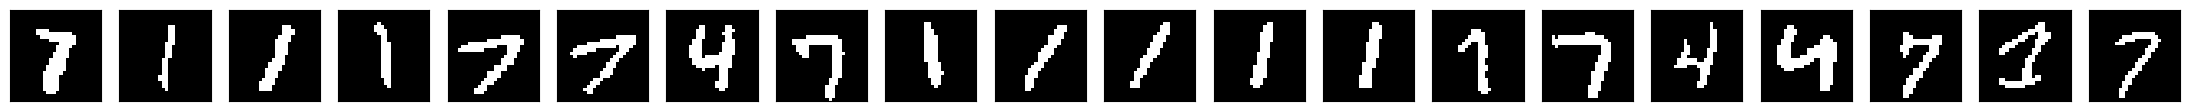

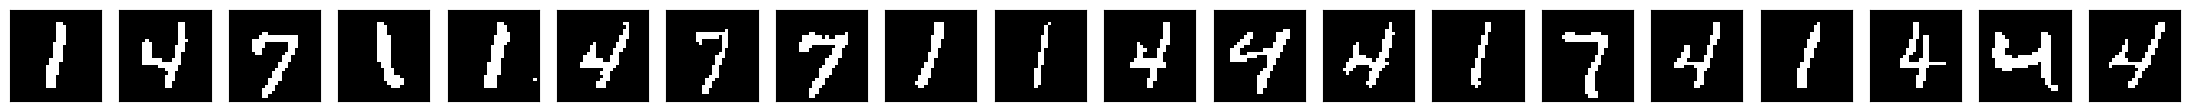

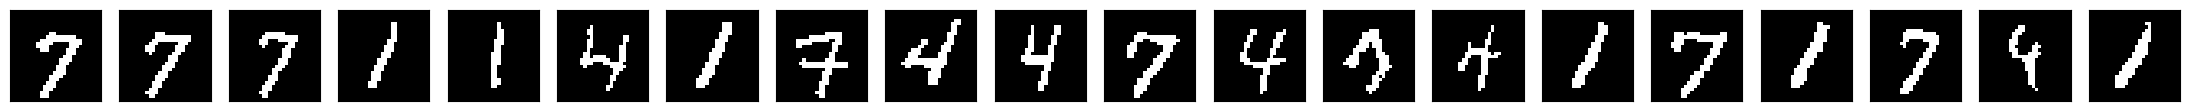

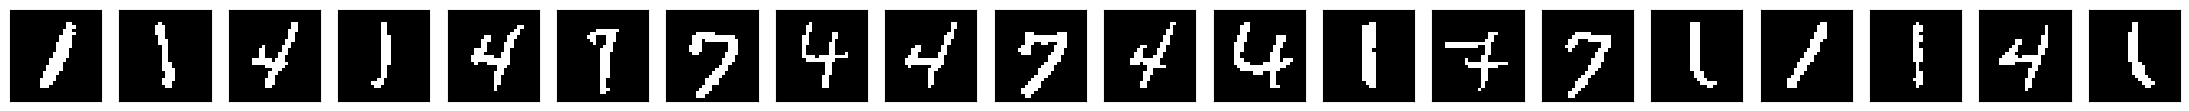

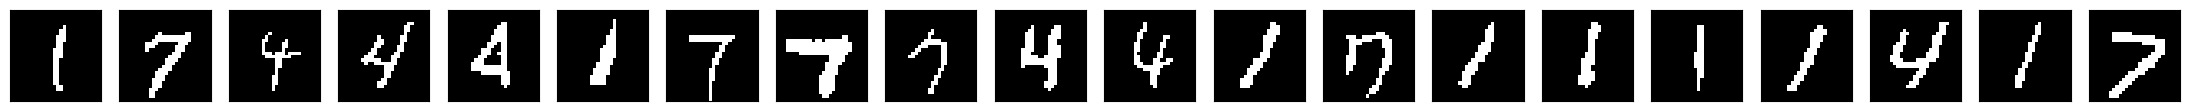

In [5]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=[0.5,1.5,3.5,4.5,6.5,7.5],density=False,rwidth=0.8,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [9]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


# RBM training 


In [10]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)+"_Nt"+str(Nt)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)


In [11]:
# random seed for reproducibility
np.random.seed(12345)

L_v = [3,4,5,6,8,10]
Nt_v= [2,4,6,8,10,15]


In [ ]:
for L in L_v:
    if L == 3:
        for Nt in Nt_v:

            # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
            w = sigma * np.random.randn(D,L)
            #a = sigma * np.random.randn(D)
            # using Hinton initialization of visible biases
            a = Hinton_bias_init(data)
            # hidden biases initialized to zero
            b = np.zeros(L)
            #print("w=",w);print("a=",a);print("b=",b)
            
            # nr of epochs
            Nepoch=150
            # minibatches per epoch
            Nmini=20
            # minibatch size at initial epoch and final one
            N_ini,N_fin=10,500
            print(f"Nepoch={Nepoch}\nNmini={Nmini}")
            
            
            # recording history of weights ("E" means epoch)
            wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
            wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
            gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
            gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
            gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
            miniE = np.zeros(Nepoch+1)
            pzE=np.zeros((Nepoch+1,Nz))
            if GRAD=="RMSprop": 
                gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
            
            indices=np.arange(Nd).astype("int")
            plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
            
            # for the plot with panels
            Ncols=min(8,max(2,L//2))
            
            if POTTS: print("Starting the training, POTTS=True")
            else: print("Starting the training")
            
            # Note: here an epoch does not analyze the whole dataset
            for epoch in range(1,1+Nepoch):
                # q maps epochs to interval [0,1]
                q = (epoch-1.)/(Nepoch-1.) 
                # N, size of the mini batch
                # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
                N = int(N_ini + (N_fin-N_ini)*(q**2))
                #  l_rate interpolates between initial and final value
                l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
            
                for mini in range(Nmini):
                    # initializitation for averages in minibatch
                    # visible variables "v" --> "x"
                    #  hidden variables "h" --> "z"
                    x_data, x_model = np.zeros(D),np.zeros(D)
                    z_data, z_model = np.zeros(L),np.zeros(L)
                    xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
                    pz = np.zeros(L)
                    
                    # Minibatch of size N: points randomply picked (without repetition) from data
                    selected = np.random.choice(indices,N,replace=False)
                    if epoch==1 and mini<=3: print(selected)
                    
                    for k in range(N):
                        ###################################
                        x0 = data[selected[k]]
                        # positive CD phase: generating z from x[k]
                        z = CD_step(x0,w,b,POTTS=POTTS)
                        x_data  += x0
                        z_data  += z
                        xz_data += np.outer(x0,z)
                        # fantasy
                        zf=np.copy(z)
                        # Contrastive divergence with Nt steps
                        for t in range(Nt):
                            # negative CD pzase: generating fantasy xf from fantasy zf
                            xf = CD_step(zf,w.T,a)
                            # positive CD phase: generating fantasy zf from fantasy xf 
                            zf = CD_step(xf,w,b,POTTS=POTTS)
                        x_model += xf
                        z_model += zf
                        xz_model+= np.outer(xf,zf)
                        # recording probability of encoding in z-space, if POTTS
                        if POTTS: pz[zf]+=1
                        ###################################
                    
                    # gradient of the likelihood: follow it along its positive direction
                    gw_d,gw_m = xz_data/N, xz_model/N
                    ga_d,ga_m = x_data/N, x_model/N
                    gb_d,gb_m = z_data/N, z_model/N
                    gw=np.copy(gw_d - gw_m)
                    ga=np.copy(ga_d - ga_m)
                    gb=np.copy(gb_d - gb_m)
            
                    # gradient ascent step
                    if GRAD=="RMSprop":
                        # RMSprop gradient ascent
                        gw2 = beta*gw2+(1-beta)*np.square(gw)
                        ga2 = beta*ga2+(1-beta)*np.square(ga)
                        gb2 = beta*gb2+(1-beta)*np.square(gb)
                        w += l_rate*gw/sqrt(epsilon+gw2)
                        a += l_rate*ga/sqrt(epsilon+ga2)
                        b += l_rate*gb/sqrt(epsilon+gb2)
                    else: 
                        # defaulting to the vanilla stochastic gradient ascent (SGD)
                        w += l_rate*gw
                        a += l_rate*ga
                        b += l_rate*gb
                    # regularization (LASSO)
                    if gamma>0.:
                        w -= (gamma*l_rate)*sign(w)
                        a -= (gamma*l_rate)*sign(a)
                        b -= (gamma*l_rate)*sign(b)
            
                wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
                aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
                bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
                miniE[epoch]=N
                if POTTS: pzE[epoch] = pz/np.sum(pz)
                print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
                      " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
            
                if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
                    plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
                        
                str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")
            save_epochs(wE,"w")
            save_epochs(bE,"b")
            save_epochs(aE,"a")

        print("END of learning phase")
        
       
    else:
        # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
        w = sigma * np.random.randn(D,L)
        #a = sigma * np.random.randn(D)
        # using Hinton initialization of visible biases
        a = Hinton_bias_init(data)
        # hidden biases initialized to zero
        b = np.zeros(L)
        #print("w=",w);print("a=",a);print("b=",b)
        
        # nr of epochs
        Nepoch=150
        # minibatches per epoch
        Nmini=20
        # minibatch size at initial epoch and final one
        N_ini,N_fin=10,500
        print(f"Nepoch={Nepoch}\nNmini={Nmini}")
        # number of CD steps
        Nt=2
        
        # recording history of weights ("E" means epoch)
        wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
        wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
        gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
        gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
        gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
        miniE = np.zeros(Nepoch+1)
        pzE=np.zeros((Nepoch+1,Nz))
        if GRAD=="RMSprop": 
            gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
        
        indices=np.arange(Nd).astype("int")
        plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
        
        # for the plot with panels
        Ncols=min(8,max(2,L//2))
        
        if POTTS: print("Starting the training, POTTS=True")
        else: print("Starting the training")
        
        # Note: here an epoch does not analyze the whole dataset
        for epoch in range(1,1+Nepoch):
            # q maps epochs to interval [0,1]
            q = (epoch-1.)/(Nepoch-1.) 
            # N, size of the mini batch
            # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
            N = int(N_ini + (N_fin-N_ini)*(q**2))
            #  l_rate interpolates between initial and final value
            l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
        
            for mini in range(Nmini):
                # initializitation for averages in minibatch
                # visible variables "v" --> "x"
                #  hidden variables "h" --> "z"
                x_data, x_model = np.zeros(D),np.zeros(D)
                z_data, z_model = np.zeros(L),np.zeros(L)
                xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
                pz = np.zeros(L)
                
                # Minibatch of size N: points randomply picked (without repetition) from data
                selected = np.random.choice(indices,N,replace=False)
                if epoch==1 and mini<=3: print(selected)
                
                for k in range(N):
                    ###################################
                    x0 = data[selected[k]]
                    # positive CD phase: generating z from x[k]
                    z = CD_step(x0,w,b,POTTS=POTTS)
                    x_data  += x0
                    z_data  += z
                    xz_data += np.outer(x0,z)
                    # fantasy
                    zf=np.copy(z)
                    # Contrastive divergence with Nt steps
                    for t in range(Nt):
                        # negative CD pzase: generating fantasy xf from fantasy zf
                        xf = CD_step(zf,w.T,a)
                        # positive CD phase: generating fantasy zf from fantasy xf 
                        zf = CD_step(xf,w,b,POTTS=POTTS)
                    x_model += xf
                    z_model += zf
                    xz_model+= np.outer(xf,zf)
                    # recording probability of encoding in z-space, if POTTS
                    if POTTS: pz[zf]+=1
                    ###################################
                
                # gradient of the likelihood: follow it along its positive direction
                gw_d,gw_m = xz_data/N, xz_model/N
                ga_d,ga_m = x_data/N, x_model/N
                gb_d,gb_m = z_data/N, z_model/N
                gw=np.copy(gw_d - gw_m)
                ga=np.copy(ga_d - ga_m)
                gb=np.copy(gb_d - gb_m)
        
                # gradient ascent step
                if GRAD=="RMSprop":
                    # RMSprop gradient ascent
                    gw2 = beta*gw2+(1-beta)*np.square(gw)
                    ga2 = beta*ga2+(1-beta)*np.square(ga)
                    gb2 = beta*gb2+(1-beta)*np.square(gb)
                    w += l_rate*gw/sqrt(epsilon+gw2)
                    a += l_rate*ga/sqrt(epsilon+ga2)
                    b += l_rate*gb/sqrt(epsilon+gb2)
                else: 
                    # defaulting to the vanilla stochastic gradient ascent (SGD)
                    w += l_rate*gw
                    a += l_rate*ga
                    b += l_rate*gb
                # regularization (LASSO)
                if gamma>0.:
                    w -= (gamma*l_rate)*sign(w)
                    a -= (gamma*l_rate)*sign(a)
                    b -= (gamma*l_rate)*sign(b)
        
            wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
            aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
            bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
            miniE[epoch]=N
            if POTTS: pzE[epoch] = pz/np.sum(pz)
            print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
                  " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
        
            if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
                plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
                    
            str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")
        
        save_epochs(wE,"w")
        save_epochs(bE,"b")
        save_epochs(aE,"a")
        print("END of learning phase")


In [ ]:
gamma_v=[0.001, 0.005, 0.01, 0.1]

for gamma in gamma_v:
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    #a = sigma * np.random.randn(D)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    #print("w=",w);print("a=",a);print("b=",b)
    
    # nr of epochs
    Nepoch=150
    # minibatches per epoch
    Nmini=20
    # minibatch size at initial epoch and final one
    N_ini,N_fin=10,500
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    
    
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    
    # Note: here an epoch does not analyze the whole dataset
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
            
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
            if epoch==1 and mini<=3: print(selected)
            
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T,a)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
            
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                w += l_rate*gw/sqrt(epsilon+gw2)
                a += l_rate*ga/sqrt(epsilon+ga2)
                b += l_rate*gb/sqrt(epsilon+gb2)
            else: 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
              " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
    
        if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
            plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
                
        str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")
    save_epochs(wE,"w")
    save_epochs(bE,"b")
    save_epochs(aE,"a")

    print("END of learning phase")

## Test generative power of the trained RBM

<Figure size 640x480 with 0 Axes>

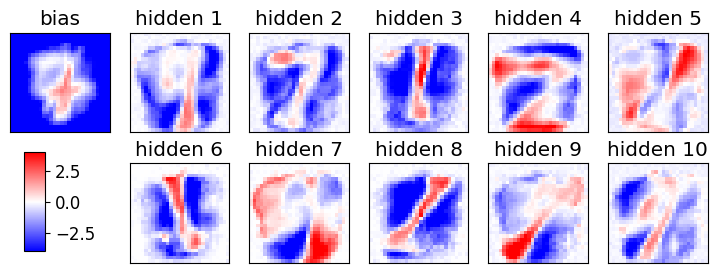

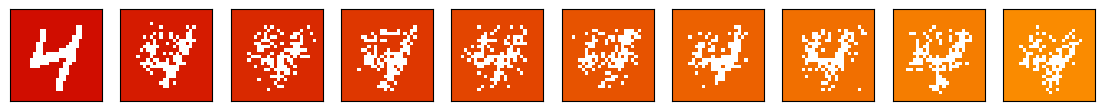

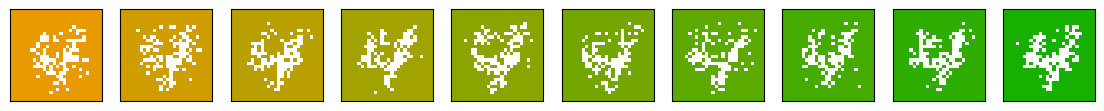

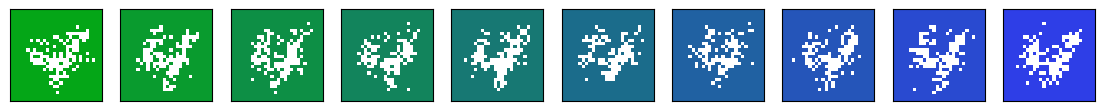

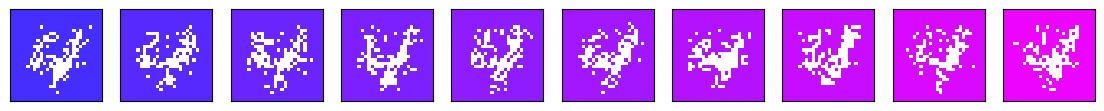

L: 10     amplification of weights: 1.0


In [15]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 150


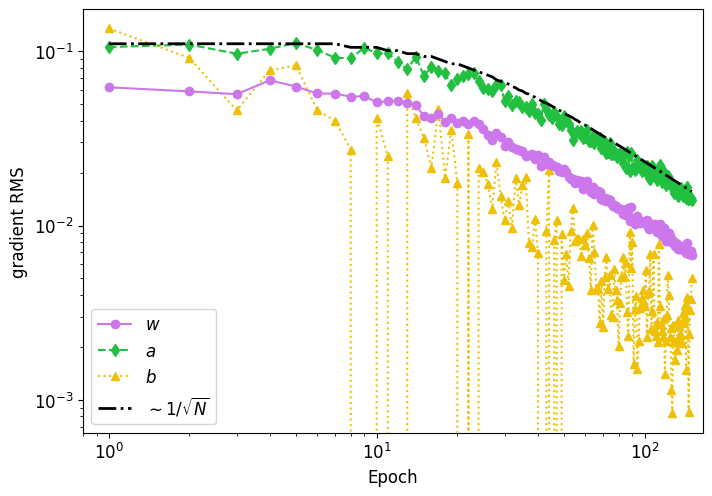

FIG/RBM_grad_MNIST3_E150_N10-500_RMSprop-0.05-0.05_CD-2_L10_reg0.001.png


In [16]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Log-likelihood calculation

In [13]:
import numpy as np
from tqdm import tqdm
import itertools as it
from scipy.optimize import curve_fit
from numba import jit

def compute_log_likelihood(w, a, b, data):

    D = w.shape[0]      #  visible units
    L = w.shape[1]    #  hidden units
    M = data.shape[0]      # data
    
    all_z = np.array(list(it.product((0, 1), repeat=L)), dtype=np.float64)  ### il dtype serve per numba
    log_likelihoods = []
    
    sample_size=int(M/4) #### take 1/4 of the data for each epoch
    idx = np.random.choice(M, sample_size, replace=False)
    data_sample = data[idx]
    log_likelihoods = []

    for m in tqdm(range(len(data_sample)), desc='Computing log-likelihood'):  
        x = data_sample[m]                                              
        log_likelihoods.append(compute_single_log_likelihood(w, a, b, x, all_z, D, L))                                                                    
        

    return np.mean(log_likelihoods)

@jit(nopython=True)
def compute_single_log_likelihood(w, a, b, x, all_z, D, L):

    q_samples = []
    for i in range(min(100, D)):  # Sample a few visible units
        for z_idx in range(min(10, 2**L)):  # Sample a few hidden states
            z = all_z[z_idx]
            H_i = a[i] + np.dot(w[i], z)
            q_samples.append(1 + np.exp(H_i))
    q = np.mean(np.array(q_samples))
    
    
    first_term = compute_free_energy_term(w, a, b, x, all_z, q, D)
    second_term = -compute_partition_function(w, a, b, all_z, q, D)
    
    return first_term + second_term



# if SPINS:
#     x_min=-1
#     level_gap=2.
# else:
#     x_min=0
#     level_gap=1.


@jit(nopython=True)
def compute_partition_function(w, a, b, all_z, q, D):

    sum_term = 0
    
    for z in all_z:
        G_z=1.0
        for i in range(L):
            G_z *= np.exp(b[i] * z[i])
        
        product_term = 1.0
        for i in range(D):
            H_i = a[i] + np.dot(w[i], z)
            product_term *= (1 + np.exp(H_i)) / q
        
        sum_term += G_z * product_term
    
    return D * np.log(q) + np.log(sum_term)

@jit(nopython=True)
def compute_free_energy_term(w, a, b, x, all_z, q, D):
    """
    Compute the free energy term using log-space arithmetic for numerical stability.
    This implements the formula: e^(-E(x,z)) = ∏_μ e^(b_μ*z_μ) * ∏_i e^(H_i(z)*x_i)
    """
    # Use log-sum-exp trick for numerical stability
    log_terms = np.zeros(len(all_z))
    
    for z_idx in range(len(all_z)):
        z = all_z[z_idx]
        
        # Compute log G(z) = log(∏_μ e^(b_μ*z_μ)) = ∑_μ b_μ*z_μ
        log_G_z = np.sum(b * z)
        
        # Compute log product term for visible units
        log_product = 0.0
        for i in range(D):
            if x[i] == 1:  # Only consider where x = 1
                H_i = a[i] + np.dot(w[i], z)
                log_product += H_i
            #if x[i] == -1:  # Only consider where x = -1
            #    H_i = a[i] + np.dot(w[i], z)
            #    log_product += (-H_i)
            ### case x=0 we have 0 (log(e^(H_z*x)=0))
        
        # Total log term for this z
        log_terms[z_idx] = log_G_z + log_product
    
    # Log-sum-exp trick: log(∑_i e^x_i) = a + log(∑_i e^(x_i - a))
    # where a = max(x_i) to prevent overflow
    if len(log_terms) > 0:
        max_log_term = np.max(log_terms)
        # Avoid -inf if all terms are -inf
        if max_log_term == -np.inf:
            return -np.inf
        
        sum_exp = np.sum(np.exp(log_terms - max_log_term))
        return max_log_term + np.log(sum_exp)
    else:
        return -np.inf  # If no hidden states, return -inf

## Likelihood evolution during the whole training  

In [25]:
# Log-likelihood evolution for different L and fixed CD steps = 2
log_like_L=[]
for L in L_v:
    Nt=2
    a_all = np.load(f"WEIGHTS/a_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
    print(f'a_all L={L}, Nt={Nt}')  ## 1 peso per visible per epoch
    b_all= np.load(f"WEIGHTS/b_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
    print(f'b_all L={L}, Nt={Nt}')  ## 1 peso per hidden per epoch
    w_all=np.load(f"WEIGHTS/w_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
    print(f'w_all L={L}, Nt={Nt}') ## matrice visible*hidden per epoch   
            
    log_like=[]
    num_epo=[]
    Nepoch=150
    n=3  ### take 1/3 of the epoch
    for i in range(Nepoch):
        if i%n==0:
            print(f'Epoch n.{i}')
            ll=compute_log_likelihood(w_all[i], a_all[i], b_all[i], data)
            log_like.append(ll)
            num_epo.append(i)
            print('Log-likelihood=',ll)
    log_like_L.append(log_like)    
        

a_all L=3, Nt=2
b_all L=3, Nt=2
w_all L=3, Nt=2
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2280.19it/s]


Log-likelihood= -167.46639562353087
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3031.66it/s]


Log-likelihood= -153.30224022268249
Epoch n.6


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2167.52it/s]


Log-likelihood= -149.29984189944383
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2140.84it/s]


Log-likelihood= -145.3430656562798
Epoch n.12


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2228.00it/s]


Log-likelihood= -150.69288269856673
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2207.40it/s]


Log-likelihood= -147.58903653630878
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2150.40it/s]


Log-likelihood= -140.05929497579703
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2251.94it/s]


Log-likelihood= -143.16418878267984
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2302.40it/s]


Log-likelihood= -141.55624860080403
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2294.57it/s]


Log-likelihood= -141.1333456533539
Epoch n.30


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2291.30it/s]


Log-likelihood= -141.77690018303306
Epoch n.33


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2282.77it/s]


Log-likelihood= -141.30056009011076
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2296.67it/s]


Log-likelihood= -137.69138747338388
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2315.90it/s]


Log-likelihood= -141.56208266171464
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3284.75it/s]


Log-likelihood= -137.1427448730522
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2332.22it/s]


Log-likelihood= -136.6715776585117
Epoch n.48


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2315.67it/s]


Log-likelihood= -135.60655794490071
Epoch n.51


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2302.72it/s]


Log-likelihood= -136.97555370675877
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2188.37it/s]


Log-likelihood= -136.72116198230265
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2232.07it/s]


Log-likelihood= -136.72376396073773
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2250.15it/s]


Log-likelihood= -137.59913726517547
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2214.07it/s]


Log-likelihood= -134.23329747002762
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2227.49it/s]


Log-likelihood= -136.91135119613836
Epoch n.69


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2308.85it/s]


Log-likelihood= -136.4325580927051
Epoch n.72


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2266.59it/s]


Log-likelihood= -137.56143278022006
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2274.37it/s]


Log-likelihood= -137.93122748254368
Epoch n.78


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2304.04it/s]


Log-likelihood= -134.52485713619993
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2256.80it/s]


Log-likelihood= -135.90228161247612
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3173.75it/s]


Log-likelihood= -136.1987229107427
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2242.66it/s]


Log-likelihood= -135.8655752782017
Epoch n.90


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2261.64it/s]


Log-likelihood= -136.20254188139637
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2271.02it/s]


Log-likelihood= -137.36244353253431
Epoch n.96


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2234.97it/s]


Log-likelihood= -136.2697933295724
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2209.58it/s]


Log-likelihood= -134.67619643569626
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2284.95it/s]


Log-likelihood= -136.39688289020455
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2247.28it/s]


Log-likelihood= -137.24671766643695
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2282.35it/s]


Log-likelihood= -137.6385311930961
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2300.91it/s]


Log-likelihood= -136.50771150303032
Epoch n.114


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2290.03it/s]


Log-likelihood= -134.9666097243515
Epoch n.117


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2267.83it/s]


Log-likelihood= -137.65680609790834
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2324.19it/s]


Log-likelihood= -137.83050152876964
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3381.49it/s]


Log-likelihood= -136.80611264490508
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2294.18it/s]


Log-likelihood= -135.14433081288252
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2207.03it/s]


Log-likelihood= -136.78365084933301
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2292.97it/s]


Log-likelihood= -136.033221252348
Epoch n.135


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2299.29it/s]


Log-likelihood= -137.88975363858924
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2305.90it/s]


Log-likelihood= -138.22442290638955
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2260.70it/s]


Log-likelihood= -134.07610994198214
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2280.65it/s]


Log-likelihood= -136.4088892031857
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2286.85it/s]


Log-likelihood= -135.02388182467786
a_all L=4, Nt=2
b_all L=4, Nt=2
w_all L=4, Nt=2
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1209.69it/s]


Log-likelihood= -167.26125039459475
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1216.18it/s]


Log-likelihood= -148.77345297407734
Epoch n.6


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:03<00:00, 1432.00it/s]


Log-likelihood= -147.61714540077304
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1189.97it/s]


Log-likelihood= -143.75963014000584
Epoch n.12


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1194.74it/s]


Log-likelihood= -145.5370454305124
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1200.22it/s]


Log-likelihood= -144.96919542433898
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1190.84it/s]


Log-likelihood= -141.04234989525747
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1189.70it/s]


Log-likelihood= -140.5357499277552
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1184.69it/s]


Log-likelihood= -139.92773109301754
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:03<00:00, 1412.31it/s]


Log-likelihood= -141.95504743208537
Epoch n.30


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1190.35it/s]


Log-likelihood= -139.5026635748997
Epoch n.33


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1174.03it/s]


Log-likelihood= -136.44388147599682
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1170.81it/s]


Log-likelihood= -138.83589854796577
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1184.39it/s]


Log-likelihood= -135.7087432673348
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1181.95it/s]


Log-likelihood= -134.73380955122218
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1131.83it/s]


Log-likelihood= -135.58305724904383
Epoch n.48


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:03<00:00, 1387.22it/s]


Log-likelihood= -135.03017099736775
Epoch n.51


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1150.97it/s]


Log-likelihood= -134.6562744112458
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 1077.46it/s]


Log-likelihood= -132.84599022684125
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 1060.63it/s]


Log-likelihood= -134.51691531235366
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1108.46it/s]


Log-likelihood= -133.39991380595978
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1118.54it/s]


Log-likelihood= -133.2852116218248
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1175.80it/s]


Log-likelihood= -133.12045972615263
Epoch n.69


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:03<00:00, 1379.67it/s]


Log-likelihood= -135.09635183992629
Epoch n.72


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1152.33it/s]


Log-likelihood= -129.49054341069063
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1125.83it/s]


Log-likelihood= -130.0545602880187
Epoch n.78


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1114.32it/s]


Log-likelihood= -127.66314905670576
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1122.44it/s]


Log-likelihood= -126.49595231999798
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1165.79it/s]


Log-likelihood= -126.06259645661025
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1369.52it/s]


Log-likelihood= -124.3657674628067
Epoch n.90


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1165.26it/s]


Log-likelihood= -126.86064155614153
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1185.44it/s]


Log-likelihood= -125.45877064842979
Epoch n.96


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1180.45it/s]


Log-likelihood= -128.0072845909842
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1182.41it/s]


Log-likelihood= -125.78873955730435
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1148.32it/s]


Log-likelihood= -126.91742723121247
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1160.25it/s]


Log-likelihood= -126.00329361906314
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1356.74it/s]


Log-likelihood= -126.64954811875906
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1151.46it/s]


Log-likelihood= -129.0202605155102
Epoch n.114


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1172.66it/s]


Log-likelihood= -126.58428108969552
Epoch n.117


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1165.97it/s]


Log-likelihood= -128.6863052766173
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1170.64it/s]


Log-likelihood= -126.13036819979084
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1124.60it/s]


Log-likelihood= -125.22974573596422
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1207.37it/s]


Log-likelihood= -125.37308332774235
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:03<00:00, 1441.02it/s]


Log-likelihood= -126.21824197434125
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1210.27it/s]


Log-likelihood= -126.10343220627901
Epoch n.135


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1181.40it/s]


Log-likelihood= -127.99399667538816
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1188.43it/s]


Log-likelihood= -128.41999321157178
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1164.82it/s]


Log-likelihood= -127.53934006948327
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1168.32it/s]


Log-likelihood= -128.02000937694777
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1166.47it/s]


Log-likelihood= -129.33495177433497
a_all L=5, Nt=2
b_all L=5, Nt=2
w_all L=5, Nt=2
Epoch n.0


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 641.59it/s]


Log-likelihood= -167.9604557873782
Epoch n.3


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 586.55it/s]


Log-likelihood= -143.5042434936922
Epoch n.6


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 574.88it/s]


Log-likelihood= -136.77885881200825
Epoch n.9


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 645.41it/s]


Log-likelihood= -132.49927277964917
Epoch n.12


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 590.51it/s]


Log-likelihood= -128.61238634453
Epoch n.15


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 565.80it/s]


Log-likelihood= -130.62356924898205
Epoch n.18


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:11<00:00, 496.62it/s]


Log-likelihood= -131.19865517214126
Epoch n.21


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 541.49it/s]


Log-likelihood= -131.11616339519205
Epoch n.24


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 557.63it/s]


Log-likelihood= -128.49605809907396
Epoch n.27


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 569.94it/s]


Log-likelihood= -129.5130036082506
Epoch n.30


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 624.45it/s]


Log-likelihood= -128.43256711944255
Epoch n.33


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 596.41it/s]


Log-likelihood= -125.50002278744955
Epoch n.36


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 573.86it/s]


Log-likelihood= -128.910749525361
Epoch n.39


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 603.61it/s]


Log-likelihood= -126.53231120632095
Epoch n.42


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 577.28it/s]


Log-likelihood= -124.67885994690177
Epoch n.45


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 584.58it/s]


Log-likelihood= -125.02436451796235
Epoch n.48


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 622.68it/s]


Log-likelihood= -125.6665963522175
Epoch n.51


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 574.92it/s]


Log-likelihood= -123.47014892566231
Epoch n.54


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 571.20it/s]


Log-likelihood= -126.03663121646501
Epoch n.57


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 561.37it/s]


Log-likelihood= -127.10812293689811
Epoch n.60


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 641.88it/s]


Log-likelihood= -128.47155501728233
Epoch n.63


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 592.78it/s]


Log-likelihood= -126.95461203569256
Epoch n.66


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 571.65it/s]


Log-likelihood= -125.64471865575088
Epoch n.69


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 622.60it/s]


Log-likelihood= -126.66414488330328
Epoch n.72


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 589.28it/s]


Log-likelihood= -124.55211452247848
Epoch n.75


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 591.06it/s]


Log-likelihood= -126.32281053476883
Epoch n.78


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 595.79it/s]


Log-likelihood= -127.85108433738776
Epoch n.81


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 644.83it/s]


Log-likelihood= -124.87571501674472
Epoch n.84


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 598.83it/s]


Log-likelihood= -124.74612735076407
Epoch n.87


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 603.76it/s]


Log-likelihood= -126.15168095391516
Epoch n.90


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 658.52it/s]


Log-likelihood= -125.69035484521923
Epoch n.93


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 599.35it/s]


Log-likelihood= -126.14069030107638
Epoch n.96


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 602.24it/s]


Log-likelihood= -124.98345671464735
Epoch n.99


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 602.85it/s]


Log-likelihood= -125.70115001417682
Epoch n.102


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 645.11it/s]


Log-likelihood= -124.9216315247487
Epoch n.105


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 542.38it/s]


Log-likelihood= -125.38063556297514
Epoch n.108


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 559.03it/s]


Log-likelihood= -124.04439094010988
Epoch n.111


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 636.08it/s]


Log-likelihood= -123.85892306720173
Epoch n.114


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 570.04it/s]


Log-likelihood= -125.25141806112585
Epoch n.117


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 582.36it/s]


Log-likelihood= -127.23410167913582
Epoch n.120


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 635.96it/s]


Log-likelihood= -125.7484513479046
Epoch n.123


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 592.36it/s]


Log-likelihood= -125.42903242262395
Epoch n.126


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 591.35it/s]


Log-likelihood= -124.25994691569801
Epoch n.129


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 590.52it/s]


Log-likelihood= -126.7666258569637
Epoch n.132


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 651.90it/s]


Log-likelihood= -124.51464281149165
Epoch n.135


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 577.32it/s]


Log-likelihood= -126.07712993983777
Epoch n.138


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 569.21it/s]


Log-likelihood= -126.0503506054616
Epoch n.141


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 648.56it/s]


Log-likelihood= -124.46543897791452
Epoch n.144


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:09<00:00, 562.36it/s]


Log-likelihood= -124.34722579993863
Epoch n.147


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 523.01it/s]


Log-likelihood= -124.68819871754732
a_all L=6, Nt=2
b_all L=6, Nt=2
w_all L=6, Nt=2
Epoch n.0


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 322.78it/s]


Log-likelihood= -167.82839428146056
Epoch n.3


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 303.20it/s]


Log-likelihood= -140.02720427633028
Epoch n.6


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 320.24it/s]


Log-likelihood= -139.66024198229758
Epoch n.9


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 308.12it/s]


Log-likelihood= -133.99796869952323
Epoch n.12


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 310.58it/s]


Log-likelihood= -134.85249625199745
Epoch n.15


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 299.19it/s]


Log-likelihood= -137.81450787649985
Epoch n.18


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:19<00:00, 287.92it/s]


Log-likelihood= -134.4462238555384
Epoch n.21


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:19<00:00, 288.60it/s]


Log-likelihood= -139.15994837219736
Epoch n.24


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:19<00:00, 285.18it/s]


Log-likelihood= -138.55250615237324
Epoch n.27


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 293.61it/s]


Log-likelihood= -135.35959551490959
Epoch n.30


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 300.52it/s]


Log-likelihood= -134.93654412212754
Epoch n.33


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:19<00:00, 286.25it/s]


Log-likelihood= -131.7890678374308
Epoch n.36


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 305.07it/s]


Log-likelihood= -134.26209234113696
Epoch n.39


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 299.58it/s]


Log-likelihood= -134.81862858782102
Epoch n.42


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 302.06it/s]


Log-likelihood= -132.4071999881581
Epoch n.45


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 295.68it/s]


Log-likelihood= -133.0928308193174
Epoch n.48


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 314.90it/s]


Log-likelihood= -136.71855341501146
Epoch n.51


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 307.46it/s]


Log-likelihood= -135.83997309166426
Epoch n.54


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 295.29it/s]


Log-likelihood= -135.58276440216045
Epoch n.57


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 306.78it/s]


Log-likelihood= -134.7011766685891
Epoch n.60


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 296.35it/s]


Log-likelihood= -132.37018226431397
Epoch n.63


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 308.38it/s]


Log-likelihood= -132.8623054511501
Epoch n.66


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 293.66it/s]


Log-likelihood= -133.73405974673514
Epoch n.69


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 310.48it/s]


Log-likelihood= -137.70880844162517
Epoch n.72


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 307.89it/s]


Log-likelihood= -133.76906177904385
Epoch n.75


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 296.28it/s]


Log-likelihood= -135.82329007814937
Epoch n.78


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 310.90it/s]


Log-likelihood= -140.06562351979912
Epoch n.81


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 293.91it/s]


Log-likelihood= -136.7601991257981
Epoch n.84


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 308.84it/s]


Log-likelihood= -141.72971189372228
Epoch n.87


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 293.68it/s]


Log-likelihood= -135.3718838464157
Epoch n.90


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 310.76it/s]


Log-likelihood= -133.20323607427235
Epoch n.93


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 310.32it/s]


Log-likelihood= -130.68581203146934
Epoch n.96


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 295.24it/s]


Log-likelihood= -136.00155483357682
Epoch n.99


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 311.95it/s]


Log-likelihood= -131.85581557846106
Epoch n.102


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 295.76it/s]


Log-likelihood= -129.7339999000464
Epoch n.105


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 304.72it/s]


Log-likelihood= -126.35954185361607
Epoch n.108


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 297.11it/s]


Log-likelihood= -128.4595016307388
Epoch n.111


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 307.95it/s]


Log-likelihood= -126.88807938696806
Epoch n.114


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 309.86it/s]


Log-likelihood= -125.6899529317442
Epoch n.117


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 296.28it/s]


Log-likelihood= -125.33446792789417
Epoch n.120


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 307.47it/s]


Log-likelihood= -126.5738726445217
Epoch n.123


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 296.63it/s]


Log-likelihood= -123.80593995360576
Epoch n.126


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 303.49it/s]


Log-likelihood= -123.88324928984012
Epoch n.129


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 300.28it/s]


Log-likelihood= -125.04275814144907
Epoch n.132


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 309.60it/s]


Log-likelihood= -127.71518491849886
Epoch n.135


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 307.98it/s]


Log-likelihood= -128.5612008303615
Epoch n.138


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 299.72it/s]


Log-likelihood= -125.00912256109461
Epoch n.141


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 312.75it/s]


Log-likelihood= -127.23541300316028
Epoch n.144


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 306.18it/s]


Log-likelihood= -125.47838408069725
Epoch n.147


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 320.70it/s]


Log-likelihood= -124.6727540876417
a_all L=8, Nt=2
b_all L=8, Nt=2
w_all L=8, Nt=2
Epoch n.0


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 79.98it/s]


Log-likelihood= -167.56168703669934
Epoch n.3


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 80.28it/s]


Log-likelihood= -142.83786419910177
Epoch n.6


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 80.15it/s]


Log-likelihood= -134.7137184134017
Epoch n.9


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:07<00:00, 81.02it/s]


Log-likelihood= -126.24903892914352
Epoch n.12


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 79.19it/s]


Log-likelihood= -128.88253273724231
Epoch n.15


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 80.60it/s]


Log-likelihood= -128.1742339970567
Epoch n.18


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 78.69it/s]


Log-likelihood= -128.95560229909577
Epoch n.21


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.86it/s]


Log-likelihood= -128.8181546339894
Epoch n.24


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.97it/s]


Log-likelihood= -128.4414534003503
Epoch n.27


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.28it/s]


Log-likelihood= -130.52554058391286
Epoch n.30


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 78.90it/s]


Log-likelihood= -128.2534474542727
Epoch n.33


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.48it/s]


Log-likelihood= -130.48209457945973
Epoch n.36


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 79.80it/s]


Log-likelihood= -125.76439216651129
Epoch n.39


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 80.29it/s]


Log-likelihood= -126.71267336416649
Epoch n.42


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 80.27it/s]


Log-likelihood= -128.1705110812231
Epoch n.45


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 79.83it/s]


Log-likelihood= -126.45442284978765
Epoch n.48


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.08it/s]


Log-likelihood= -128.3739525610633
Epoch n.51


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.37it/s]


Log-likelihood= -128.664186336212
Epoch n.54


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.18it/s]


Log-likelihood= -131.55238834556386
Epoch n.57


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.47it/s]


Log-likelihood= -127.50814445454051
Epoch n.60


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.27it/s]


Log-likelihood= -129.170238548205
Epoch n.63


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 78.55it/s]


Log-likelihood= -131.6875389651791
Epoch n.66


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.14it/s]


Log-likelihood= -129.65844807103835
Epoch n.69


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.48it/s]


Log-likelihood= -125.78235323946345
Epoch n.72


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.91it/s]


Log-likelihood= -130.29459529188648
Epoch n.75


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.49it/s]


Log-likelihood= -131.34455808758614
Epoch n.78


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 78.65it/s]


Log-likelihood= -126.9536172816826
Epoch n.81


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 79.48it/s]


Log-likelihood= -129.07105531107402
Epoch n.84


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.25it/s]


Log-likelihood= -128.17530346076106
Epoch n.87


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.20it/s]


Log-likelihood= -126.02669720337981
Epoch n.90


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.79it/s]


Log-likelihood= -131.33470877085202
Epoch n.93


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.27it/s]


Log-likelihood= -128.11064690394153
Epoch n.96


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.20it/s]


Log-likelihood= -130.0169910334589
Epoch n.99


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.47it/s]


Log-likelihood= -131.84500780429315
Epoch n.102


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.18it/s]


Log-likelihood= -128.82380969991922
Epoch n.105


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.09it/s]


Log-likelihood= -132.14912456756852
Epoch n.108


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.53it/s]


Log-likelihood= -133.26551384704422
Epoch n.111


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.36it/s]


Log-likelihood= -133.2026034645289
Epoch n.114


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 80.15it/s]


Log-likelihood= -133.92757163398437
Epoch n.117


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.35it/s]


Log-likelihood= -133.39419064156726
Epoch n.120


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.25it/s]


Log-likelihood= -136.0273791310948
Epoch n.123


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.58it/s]


Log-likelihood= -135.303745555103
Epoch n.126


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.13it/s]


Log-likelihood= -135.6643037995829
Epoch n.129


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.06it/s]


Log-likelihood= -135.8692238818429
Epoch n.132


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.54it/s]


Log-likelihood= -138.0868459747056
Epoch n.135


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.15it/s]


Log-likelihood= -140.62545217619865
Epoch n.138


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.29it/s]


Log-likelihood= -143.24514671460466
Epoch n.141


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 78.79it/s]


Log-likelihood= -138.7612876385819
Epoch n.144


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.47it/s]


Log-likelihood= -139.71833383593813
Epoch n.147


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.42it/s]


Log-likelihood= -143.29595281618663
a_all L=10, Nt=2
b_all L=10, Nt=2
w_all L=10, Nt=2
Epoch n.0


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:45<00:00, 19.29it/s]


Log-likelihood= -168.02160816075647
Epoch n.3


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:41<00:00, 19.54it/s]


Log-likelihood= -136.49303448120102
Epoch n.6


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:44<00:00, 19.33it/s]


Log-likelihood= -124.54118527537752
Epoch n.9


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:47<00:00, 19.16it/s]


Log-likelihood= -123.2101202445941
Epoch n.12


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:47<00:00, 19.14it/s]


Log-likelihood= -126.51225332670599
Epoch n.15


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:46<00:00, 19.18it/s]


Log-likelihood= -125.12327950438193
Epoch n.18


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:45<00:00, 19.26it/s]


Log-likelihood= -124.40559293652244
Epoch n.21


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:45<00:00, 19.23it/s]


Log-likelihood= -127.38053124263723
Epoch n.24


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:46<00:00, 19.18it/s]


Log-likelihood= -125.1567271303564
Epoch n.27


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:47<00:00, 19.16it/s]


Log-likelihood= -121.98535241443783
Epoch n.30


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:46<00:00, 19.18it/s]


Log-likelihood= -123.60695775429551
Epoch n.33


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:48<00:00, 19.05it/s]


Log-likelihood= -129.92706931389054
Epoch n.36


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:48<00:00, 19.04it/s]


Log-likelihood= -130.94066255096385
Epoch n.39


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:47<00:00, 19.10it/s]


Log-likelihood= -132.80274194612247
Epoch n.42


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:49<00:00, 18.97it/s]


Log-likelihood= -131.06788914719718
Epoch n.45


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:53<00:00, 18.76it/s]


Log-likelihood= -130.34176869750894
Epoch n.48


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:55<00:00, 18.63it/s]


Log-likelihood= -126.19269970250967
Epoch n.51


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:50<00:00, 18.94it/s]


Log-likelihood= -128.69649993706233
Epoch n.54


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:52<00:00, 18.77it/s]


Log-likelihood= -130.84296852633315
Epoch n.57


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:47<00:00, 19.14it/s]


Log-likelihood= -124.85462726189246
Epoch n.60


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:53<00:00, 18.72it/s]


Log-likelihood= -126.11755522589188
Epoch n.63


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:58<00:00, 18.44it/s]


Log-likelihood= -125.34316467014854
Epoch n.66


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:46<00:00, 19.19it/s]


Log-likelihood= -121.38894789975254
Epoch n.69


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:42<00:00, 19.47it/s]


Log-likelihood= -123.22057435781281
Epoch n.72


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.01it/s]


Log-likelihood= -125.12626840611875
Epoch n.75


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.99it/s]


Log-likelihood= -125.49042897052719
Epoch n.78


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.02it/s]


Log-likelihood= -123.69047746321647
Epoch n.81


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:36<00:00, 19.92it/s]


Log-likelihood= -124.52384664143102
Epoch n.84


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.02it/s]


Log-likelihood= -123.84783020367134
Epoch n.87


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.06it/s]


Log-likelihood= -121.14757321357567
Epoch n.90


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.98it/s]


Log-likelihood= -121.07578731147076
Epoch n.93


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.98it/s]


Log-likelihood= -118.55811729408404
Epoch n.96


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.03it/s]


Log-likelihood= -116.78297451371358
Epoch n.99


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.01it/s]


Log-likelihood= -119.48616377020674
Epoch n.102


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.92it/s]


Log-likelihood= -114.13198262910228
Epoch n.105


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.05it/s]


Log-likelihood= -116.30035041097378
Epoch n.108


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.02it/s]


Log-likelihood= -116.30145241891645
Epoch n.111


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.00it/s]


Log-likelihood= -119.42028825152487
Epoch n.114


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.03it/s]


Log-likelihood= -116.14413511129851
Epoch n.117


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.98it/s]


Log-likelihood= -118.27649553258439
Epoch n.120


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.01it/s]


Log-likelihood= -116.78625212743452
Epoch n.123


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.01it/s]


Log-likelihood= -116.23294539232789
Epoch n.126


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.06it/s]


Log-likelihood= -120.18589175574884
Epoch n.129


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.98it/s]


Log-likelihood= -119.71331765630502
Epoch n.132


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.98it/s]


Log-likelihood= -121.27313234672091
Epoch n.135


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.01it/s]


Log-likelihood= -117.06862339922307
Epoch n.138


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:33<00:00, 20.08it/s]


Log-likelihood= -116.79509888869605
Epoch n.141


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.01it/s]


Log-likelihood= -118.99634972903671
Epoch n.144


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:36<00:00, 19.91it/s]


Log-likelihood= -114.57554406077575
Epoch n.147


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:35<00:00, 19.95it/s]

Log-likelihood= -119.01322526073503


In [14]:
log_like_cd=[]

# Log-likelihood evolution for fixed L=3 and different CD steps

for L in L_v:
    if L==3:
        for Nt in Nt_v:
            a_all = np.load(f"WEIGHTS/a_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
            print(f'a_all L={L}, Nt={Nt}')  ## 1 peso per visible per epoch
            b_all= np.load(f"WEIGHTS/b_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
            print(f'b_all L={L}, Nt={Nt}')  ## 1 peso per hidden per epoch
            w_all=np.load(f"WEIGHTS/w_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
            print(f'w_all L={L}, Nt={Nt}') ## matrice visible*hidden per epoch   
            
            log_like=[]
            num_epo=[]
            Nepoch=150
            n=3  ### take 1/3 of the epoch
            for i in range(Nepoch):
                if i%n==0:
                    print(f'Epoch n.{i}')
                    ll=compute_log_likelihood(w_all[i], a_all[i], b_all[i], data)
                    log_like.append(ll)
                    num_epo.append(i)
                    print('Log-likelihood=',ll)
            log_like_cd.append(log_like)    

a_all L=3, Nt=2
b_all L=3, Nt=2
w_all L=3, Nt=2
Epoch n.0


Computing log-likelihood:   0%|                                                                | 0/5498 [00:00<?, ?it/s]/tmp/ipykernel_681/779657587.py:41: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  second_term = -compute_partition_function(w, a, b, all_z, q, D)
Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:07<00:00, 770.57it/s]


Log-likelihood= -167.0619582470125
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1232.37it/s]


Log-likelihood= -153.91380773196778
Epoch n.6


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 910.76it/s]


Log-likelihood= -150.79911203045867
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1228.20it/s]


Log-likelihood= -146.18286317167184
Epoch n.12


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1263.60it/s]


Log-likelihood= -150.7975139446413
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1238.64it/s]


Log-likelihood= -145.83368565576026
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1240.14it/s]


Log-likelihood= -141.8379678125805
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1267.99it/s]


Log-likelihood= -143.07079172851942
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1222.20it/s]


Log-likelihood= -140.99871912316317
Epoch n.27


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 949.04it/s]


Log-likelihood= -142.12682516332038
Epoch n.30


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.82it/s]


Log-likelihood= -142.22555042710545
Epoch n.33


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1248.07it/s]


Log-likelihood= -140.4195790171541
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1228.18it/s]


Log-likelihood= -136.61794028844332
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1203.60it/s]


Log-likelihood= -140.7232094456506
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1194.89it/s]


Log-likelihood= -137.02533088838942
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1225.04it/s]


Log-likelihood= -137.24895116667676
Epoch n.48


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 906.42it/s]


Log-likelihood= -135.54764095984305
Epoch n.51


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1235.00it/s]


Log-likelihood= -137.10179325629935
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1211.42it/s]


Log-likelihood= -136.4280190549347
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1230.77it/s]


Log-likelihood= -136.0602139530983
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1211.36it/s]


Log-likelihood= -136.78500666781412
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1191.30it/s]


Log-likelihood= -134.84579821080163
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1188.08it/s]


Log-likelihood= -137.9025134591677
Epoch n.69


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 907.00it/s]


Log-likelihood= -136.38151146505055
Epoch n.72


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1214.63it/s]


Log-likelihood= -135.99726567713552
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1283.27it/s]


Log-likelihood= -137.06047926507108
Epoch n.78


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1280.33it/s]


Log-likelihood= -135.30578629736476
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1256.05it/s]


Log-likelihood= -137.31241494184835
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1210.18it/s]


Log-likelihood= -136.47912744683077
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1235.31it/s]


Log-likelihood= -136.41121429688255
Epoch n.90


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 952.78it/s]


Log-likelihood= -136.17395894916874
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1277.62it/s]


Log-likelihood= -138.0128243180918
Epoch n.96


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1223.26it/s]


Log-likelihood= -136.45627614196752
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1231.80it/s]


Log-likelihood= -135.18712117774922
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1290.66it/s]


Log-likelihood= -135.66665644578342
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1251.38it/s]


Log-likelihood= -136.1487433065035
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1230.72it/s]


Log-likelihood= -137.32125230815697
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1209.89it/s]


Log-likelihood= -136.39701093756725
Epoch n.114


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 937.73it/s]


Log-likelihood= -136.0396811463683
Epoch n.117


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.36it/s]


Log-likelihood= -137.0263635392604
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1275.57it/s]


Log-likelihood= -137.27674244462864
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1224.63it/s]


Log-likelihood= -136.3430194145506
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1251.73it/s]


Log-likelihood= -134.91024641798245
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1254.12it/s]


Log-likelihood= -136.45110741263926
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1233.69it/s]


Log-likelihood= -135.25465109010926
Epoch n.135


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 970.00it/s]


Log-likelihood= -138.50978350410554
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1204.74it/s]


Log-likelihood= -137.53445534268457
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1315.34it/s]


Log-likelihood= -135.25248446687726
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1293.21it/s]


Log-likelihood= -134.7393113270953
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1349.08it/s]


Log-likelihood= -135.50172222870538
a_all L=3, Nt=4
b_all L=3, Nt=4
w_all L=3, Nt=4
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1283.75it/s]


Log-likelihood= -167.36940146232564
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1256.07it/s]


Log-likelihood= -151.43773272715717
Epoch n.6


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 896.82it/s]


Log-likelihood= -144.3845672898909
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1198.08it/s]


Log-likelihood= -143.56116545836343
Epoch n.12


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1269.06it/s]


Log-likelihood= -143.3527488061263
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1300.68it/s]


Log-likelihood= -144.96469604835798
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1245.40it/s]


Log-likelihood= -142.3012742833728
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1272.85it/s]


Log-likelihood= -144.398954662032
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1261.93it/s]


Log-likelihood= -141.7963459418535
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1254.79it/s]


Log-likelihood= -136.9520382794936
Epoch n.30


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 891.64it/s]


Log-likelihood= -135.63967127927643
Epoch n.33


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.67it/s]


Log-likelihood= -136.30290107990388
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1333.90it/s]


Log-likelihood= -133.89693107867691
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1228.42it/s]


Log-likelihood= -134.99542196672812
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.53it/s]


Log-likelihood= -133.84014328659825
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1238.52it/s]


Log-likelihood= -133.29639517749263
Epoch n.48


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1267.71it/s]


Log-likelihood= -136.0565559487416
Epoch n.51


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 898.17it/s]


Log-likelihood= -134.6582134468092
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1225.51it/s]


Log-likelihood= -135.177865176888
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.43it/s]


Log-likelihood= -132.00759638737156
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1228.68it/s]


Log-likelihood= -133.59414596591458
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1313.61it/s]


Log-likelihood= -131.81053497207705
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1284.74it/s]


Log-likelihood= -133.43774761751385
Epoch n.69


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1232.19it/s]


Log-likelihood= -131.84274459764572
Epoch n.72


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 867.37it/s]


Log-likelihood= -134.4900621721476
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1260.81it/s]


Log-likelihood= -132.17387960725944
Epoch n.78


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.63it/s]


Log-likelihood= -130.82083706899934
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1256.74it/s]


Log-likelihood= -132.4570817997721
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1270.64it/s]


Log-likelihood= -132.46815091715993
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1294.71it/s]


Log-likelihood= -131.7122546405801
Epoch n.90


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.46it/s]


Log-likelihood= -132.73711857846368
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.65it/s]


Log-likelihood= -136.3271404346707
Epoch n.96


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 839.53it/s]


Log-likelihood= -131.37788768183972
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1214.22it/s]


Log-likelihood= -131.6937956044197
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1260.28it/s]


Log-likelihood= -132.68132608309315
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1230.24it/s]


Log-likelihood= -133.2517339791439
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1254.40it/s]


Log-likelihood= -131.1810143942101
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1252.16it/s]


Log-likelihood= -132.44167619085445
Epoch n.114


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1261.44it/s]


Log-likelihood= -132.66020855132223
Epoch n.117


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 956.63it/s]


Log-likelihood= -132.3814993435518
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.37it/s]


Log-likelihood= -132.50923720927764
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.09it/s]


Log-likelihood= -131.42889961780284
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1233.71it/s]


Log-likelihood= -132.5620227199188
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1220.10it/s]


Log-likelihood= -132.43300186401777
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.91it/s]


Log-likelihood= -133.42060307796527
Epoch n.135


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.80it/s]


Log-likelihood= -132.09346580783387
Epoch n.138


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 901.65it/s]


Log-likelihood= -131.87058058883463
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1249.32it/s]


Log-likelihood= -134.57359530666105
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1274.77it/s]


Log-likelihood= -130.6430868309253
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1272.11it/s]


Log-likelihood= -131.71583986828782
a_all L=3, Nt=6
b_all L=3, Nt=6
w_all L=3, Nt=6
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1249.86it/s]


Log-likelihood= -166.7634028764675
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1260.69it/s]


Log-likelihood= -151.15352518686646
Epoch n.6


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1266.06it/s]


Log-likelihood= -146.27894989351333
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1244.21it/s]


Log-likelihood= -142.690763221806
Epoch n.12


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 897.87it/s]


Log-likelihood= -147.71445502255128
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1278.30it/s]


Log-likelihood= -141.4454504162074
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1261.10it/s]


Log-likelihood= -142.45002446620478
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1241.77it/s]


Log-likelihood= -144.102879912941
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1257.02it/s]


Log-likelihood= -141.17957245293158
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.81it/s]


Log-likelihood= -140.6371147404727
Epoch n.30


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1231.23it/s]


Log-likelihood= -140.62353996101098
Epoch n.33


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 917.21it/s]


Log-likelihood= -139.85141189192692
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.81it/s]


Log-likelihood= -139.5033773228586
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1271.90it/s]


Log-likelihood= -140.37725486133374
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1233.09it/s]


Log-likelihood= -137.50988469891493
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1260.98it/s]


Log-likelihood= -135.0570553043074
Epoch n.48


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1239.95it/s]


Log-likelihood= -136.99723130659953
Epoch n.51


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1232.13it/s]


Log-likelihood= -136.55809345366367
Epoch n.54


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 916.64it/s]


Log-likelihood= -136.42198081143192
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1240.09it/s]


Log-likelihood= -137.28494160963143
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1229.15it/s]


Log-likelihood= -140.75155583266866
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1249.45it/s]


Log-likelihood= -139.42824707760516
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1235.01it/s]


Log-likelihood= -137.13251909571457
Epoch n.69


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1225.73it/s]


Log-likelihood= -136.08375759162547
Epoch n.72


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1254.79it/s]


Log-likelihood= -136.37213302683818
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1271.42it/s]


Log-likelihood= -136.59410698361526
Epoch n.78


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 879.84it/s]


Log-likelihood= -136.00938083701752
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1225.33it/s]


Log-likelihood= -137.5678988128239
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1236.84it/s]


Log-likelihood= -136.10471054977847
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1256.47it/s]


Log-likelihood= -137.29371668635915
Epoch n.90


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1239.31it/s]


Log-likelihood= -137.8961458059041
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.05it/s]


Log-likelihood= -138.4513244625272
Epoch n.96


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1257.29it/s]


Log-likelihood= -135.87242493666943
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1224.95it/s]


Log-likelihood= -136.44733559063818
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1261.26it/s]


Log-likelihood= -137.00195069618383
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.31it/s]


Log-likelihood= -136.86439670673303
Epoch n.108


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 815.37it/s]


Log-likelihood= -134.7454175841513
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.92it/s]


Log-likelihood= -137.75032469458253
Epoch n.114


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.32it/s]


Log-likelihood= -137.78079650353163
Epoch n.117


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.60it/s]


Log-likelihood= -136.9083287967815
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1252.70it/s]


Log-likelihood= -139.2609880056879
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1264.45it/s]


Log-likelihood= -137.4908654551755
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1241.15it/s]


Log-likelihood= -137.67328807466222
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1264.60it/s]


Log-likelihood= -138.69091278034927
Epoch n.132


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 898.12it/s]


Log-likelihood= -136.66958834478174
Epoch n.135


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1246.51it/s]


Log-likelihood= -138.29734077361582
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1249.19it/s]


Log-likelihood= -138.16385850538117
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1244.26it/s]


Log-likelihood= -138.38227959002984
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1268.34it/s]


Log-likelihood= -137.01459933025427
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1275.15it/s]


Log-likelihood= -138.7525759228951
a_all L=3, Nt=8
b_all L=3, Nt=8
w_all L=3, Nt=8
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1243.13it/s]


Log-likelihood= -167.31564281850328
Epoch n.3


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 913.72it/s]


Log-likelihood= -150.35861217693633
Epoch n.6


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.55it/s]


Log-likelihood= -144.29489631159421
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1246.61it/s]


Log-likelihood= -142.13831512765285
Epoch n.12


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1241.30it/s]


Log-likelihood= -147.16972180838596
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1232.34it/s]


Log-likelihood= -141.0404683278056
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.99it/s]


Log-likelihood= -139.74240721315616
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1227.65it/s]


Log-likelihood= -142.73999370693215
Epoch n.24


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 916.81it/s]


Log-likelihood= -140.16049708519932
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.83it/s]


Log-likelihood= -143.15510121602594
Epoch n.30


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.91it/s]


Log-likelihood= -140.90457871997285
Epoch n.33


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1239.65it/s]


Log-likelihood= -139.22911230905567
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1268.38it/s]


Log-likelihood= -141.2804208852259
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1243.31it/s]


Log-likelihood= -138.64478475085116
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.33it/s]


Log-likelihood= -143.0623838945089
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1273.84it/s]


Log-likelihood= -137.07448907598345
Epoch n.48


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 926.71it/s]


Log-likelihood= -140.5984547727017
Epoch n.51


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1217.29it/s]


Log-likelihood= -140.9587831158454
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1226.93it/s]


Log-likelihood= -138.50455965817602
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1232.14it/s]


Log-likelihood= -136.50814773019974
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1226.97it/s]


Log-likelihood= -134.39514179476876
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1244.80it/s]


Log-likelihood= -132.50361026174025
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1239.07it/s]


Log-likelihood= -131.3766467997649
Epoch n.69


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 883.92it/s]


Log-likelihood= -132.33407555424958
Epoch n.72


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1216.80it/s]


Log-likelihood= -130.9411932820327
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.62it/s]


Log-likelihood= -131.71599215293935
Epoch n.78


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1294.58it/s]


Log-likelihood= -130.72131673472666
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1276.64it/s]


Log-likelihood= -131.5507384529515
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1276.57it/s]


Log-likelihood= -131.6547504762219
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.51it/s]


Log-likelihood= -132.20397535514192
Epoch n.90


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 852.84it/s]


Log-likelihood= -132.3993321016373
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.41it/s]


Log-likelihood= -133.73495199250806
Epoch n.96


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1254.18it/s]


Log-likelihood= -132.18985968909453
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.49it/s]


Log-likelihood= -131.22713267169217
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1236.38it/s]


Log-likelihood= -132.23505959142645
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.68it/s]


Log-likelihood= -132.81279748245015
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1247.40it/s]


Log-likelihood= -132.2461470620024
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1244.35it/s]


Log-likelihood= -132.4716930709083
Epoch n.114


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 910.99it/s]


Log-likelihood= -131.40155804987614
Epoch n.117


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1245.19it/s]


Log-likelihood= -132.09725856214712
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1246.10it/s]


Log-likelihood= -131.6298966380341
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1258.07it/s]


Log-likelihood= -132.1806173753379
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.37it/s]


Log-likelihood= -132.13322236118844
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1266.51it/s]


Log-likelihood= -132.06134592628803
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1273.08it/s]


Log-likelihood= -132.48208518200497
Epoch n.135


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 884.69it/s]


Log-likelihood= -132.0035838441319
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1267.09it/s]


Log-likelihood= -130.78705168973687
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1246.89it/s]


Log-likelihood= -131.87597167461564
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1237.15it/s]


Log-likelihood= -131.43193712314883
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1243.09it/s]


Log-likelihood= -130.04848288318848
a_all L=3, Nt=10
b_all L=3, Nt=10
w_all L=3, Nt=10
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1252.67it/s]


Log-likelihood= -167.47056590756083
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1247.55it/s]


Log-likelihood= -152.78426780693434
Epoch n.6


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:05<00:00, 938.12it/s]


Log-likelihood= -148.5082170896151
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1238.49it/s]


Log-likelihood= -149.18253967706548
Epoch n.12


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1213.26it/s]


Log-likelihood= -145.98741749321914
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.67it/s]


Log-likelihood= -139.4214199220991
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1243.58it/s]


Log-likelihood= -139.24265310905963
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1258.49it/s]


Log-likelihood= -138.7342858108394
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1245.03it/s]


Log-likelihood= -135.40335746895434
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1267.83it/s]


Log-likelihood= -139.47881685966775
Epoch n.30


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 891.35it/s]


Log-likelihood= -138.65822662770162
Epoch n.33


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1275.02it/s]


Log-likelihood= -135.30143410885884
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1235.58it/s]


Log-likelihood= -135.17698744360462
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1267.56it/s]


Log-likelihood= -139.56140381506125
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1257.57it/s]


Log-likelihood= -133.9219437081514
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1248.16it/s]


Log-likelihood= -135.93916219844047
Epoch n.48


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.36it/s]


Log-likelihood= -136.43983222328924
Epoch n.51


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 874.04it/s]


Log-likelihood= -136.8590577664586
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1220.21it/s]


Log-likelihood= -138.47885274867622
Epoch n.57


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1228.54it/s]


Log-likelihood= -137.53233337674422
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.27it/s]


Log-likelihood= -139.25807740849527
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1257.50it/s]


Log-likelihood= -138.09750044385825
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.94it/s]


Log-likelihood= -138.88606529130746
Epoch n.69


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1248.08it/s]


Log-likelihood= -138.20988583942773
Epoch n.72


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 888.36it/s]


Log-likelihood= -140.86382655618718
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1217.13it/s]


Log-likelihood= -136.72671812396788
Epoch n.78


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1212.05it/s]


Log-likelihood= -139.1053296960345
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1323.28it/s]


Log-likelihood= -138.0744965854004
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1268.30it/s]


Log-likelihood= -139.40683765388803
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1260.49it/s]


Log-likelihood= -138.48899084780825
Epoch n.90


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1233.78it/s]


Log-likelihood= -137.93185797478017
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1261.77it/s]


Log-likelihood= -138.01088857944683
Epoch n.96


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 867.62it/s]


Log-likelihood= -138.90194016356588
Epoch n.99


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1246.11it/s]


Log-likelihood= -139.34268786990438
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1258.97it/s]


Log-likelihood= -138.23128831900493
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1220.89it/s]


Log-likelihood= -138.65132015277578
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1321.52it/s]


Log-likelihood= -138.26414390146837
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1258.47it/s]


Log-likelihood= -139.74424879531273
Epoch n.114


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1260.26it/s]


Log-likelihood= -137.91656112923917
Epoch n.117


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 896.23it/s]


Log-likelihood= -138.5140110170626
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1221.94it/s]


Log-likelihood= -139.44086498166567
Epoch n.123


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1282.22it/s]


Log-likelihood= -139.77781710663538
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1329.14it/s]


Log-likelihood= -140.43495970528335
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1284.53it/s]


Log-likelihood= -139.17682656849638
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1258.04it/s]


Log-likelihood= -138.8048585606388
Epoch n.135


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.05it/s]


Log-likelihood= -140.13499742601536
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1223.99it/s]


Log-likelihood= -139.00813222817635
Epoch n.141


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 829.76it/s]


Log-likelihood= -138.00225444937234
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1222.58it/s]


Log-likelihood= -139.9386178315608
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1251.62it/s]


Log-likelihood= -137.73756883377519
a_all L=3, Nt=15
b_all L=3, Nt=15
w_all L=3, Nt=15
Epoch n.0


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1271.31it/s]


Log-likelihood= -167.56688305548167
Epoch n.3


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1326.03it/s]


Log-likelihood= -149.57459003697164
Epoch n.6


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1306.80it/s]


Log-likelihood= -148.92201576745612
Epoch n.9


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1272.40it/s]


Log-likelihood= -144.49699483912954
Epoch n.12


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 888.95it/s]


Log-likelihood= -142.65000422223918
Epoch n.15


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.77it/s]


Log-likelihood= -140.4280441424735
Epoch n.18


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1254.11it/s]


Log-likelihood= -141.7448350819875
Epoch n.21


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1250.48it/s]


Log-likelihood= -137.7395302170032
Epoch n.24


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1313.94it/s]


Log-likelihood= -139.69429142694176
Epoch n.27


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.21it/s]


Log-likelihood= -139.14603038264303
Epoch n.30


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1262.13it/s]


Log-likelihood= -137.47472515699013
Epoch n.33


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 864.12it/s]


Log-likelihood= -136.56899743627926
Epoch n.36


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1226.07it/s]


Log-likelihood= -135.74029496060325
Epoch n.39


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1268.21it/s]


Log-likelihood= -134.7535182435389
Epoch n.42


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1312.98it/s]


Log-likelihood= -134.72844823472388
Epoch n.45


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1297.33it/s]


Log-likelihood= -133.1559386275543
Epoch n.48


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1294.03it/s]


Log-likelihood= -130.79011379950413
Epoch n.51


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1242.33it/s]


Log-likelihood= -132.93062435337276
Epoch n.54


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1231.01it/s]


Log-likelihood= -132.32729123124594
Epoch n.57


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 842.44it/s]


Log-likelihood= -132.41780205522238
Epoch n.60


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.63it/s]


Log-likelihood= -132.41892985284332
Epoch n.63


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1286.70it/s]


Log-likelihood= -130.78128991619275
Epoch n.66


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1268.34it/s]


Log-likelihood= -134.29778060803926
Epoch n.69


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1271.72it/s]


Log-likelihood= -131.76417546286368
Epoch n.72


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1268.82it/s]


Log-likelihood= -134.36682334482597
Epoch n.75


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1252.78it/s]


Log-likelihood= -133.78541633013467
Epoch n.78


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 835.17it/s]


Log-likelihood= -132.22659407271274
Epoch n.81


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.03it/s]


Log-likelihood= -132.87452002843142
Epoch n.84


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1328.76it/s]


Log-likelihood= -133.4962397486291
Epoch n.87


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1285.67it/s]


Log-likelihood= -132.5756679147564
Epoch n.90


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1244.27it/s]


Log-likelihood= -133.15314231772024
Epoch n.93


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.68it/s]


Log-likelihood= -132.49289832972585
Epoch n.96


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1267.88it/s]


Log-likelihood= -132.94989403257628
Epoch n.99


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 879.64it/s]


Log-likelihood= -133.0811427254383
Epoch n.102


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1209.20it/s]


Log-likelihood= -133.8124582305792
Epoch n.105


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1247.08it/s]


Log-likelihood= -131.95613970263906
Epoch n.108


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1278.35it/s]


Log-likelihood= -132.75947195120915
Epoch n.111


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1297.47it/s]


Log-likelihood= -135.04058371731935
Epoch n.114


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1277.63it/s]


Log-likelihood= -133.29644008628742
Epoch n.117


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1251.68it/s]


Log-likelihood= -135.2445799408096
Epoch n.120


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1224.79it/s]


Log-likelihood= -132.32634395848908
Epoch n.123


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 862.72it/s]


Log-likelihood= -133.11409381249797
Epoch n.126


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1276.75it/s]


Log-likelihood= -132.77708319663932
Epoch n.129


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1291.86it/s]


Log-likelihood= -132.51737443109675
Epoch n.132


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1286.30it/s]


Log-likelihood= -134.48169441349756
Epoch n.135


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1234.64it/s]


Log-likelihood= -136.69788209698285
Epoch n.138


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1253.09it/s]


Log-likelihood= -134.37401879695435
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1216.45it/s]


Log-likelihood= -134.83789470261087
Epoch n.144


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:06<00:00, 829.85it/s]


Log-likelihood= -134.21187632877076
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1257.72it/s]

Log-likelihood= -133.59259213577883


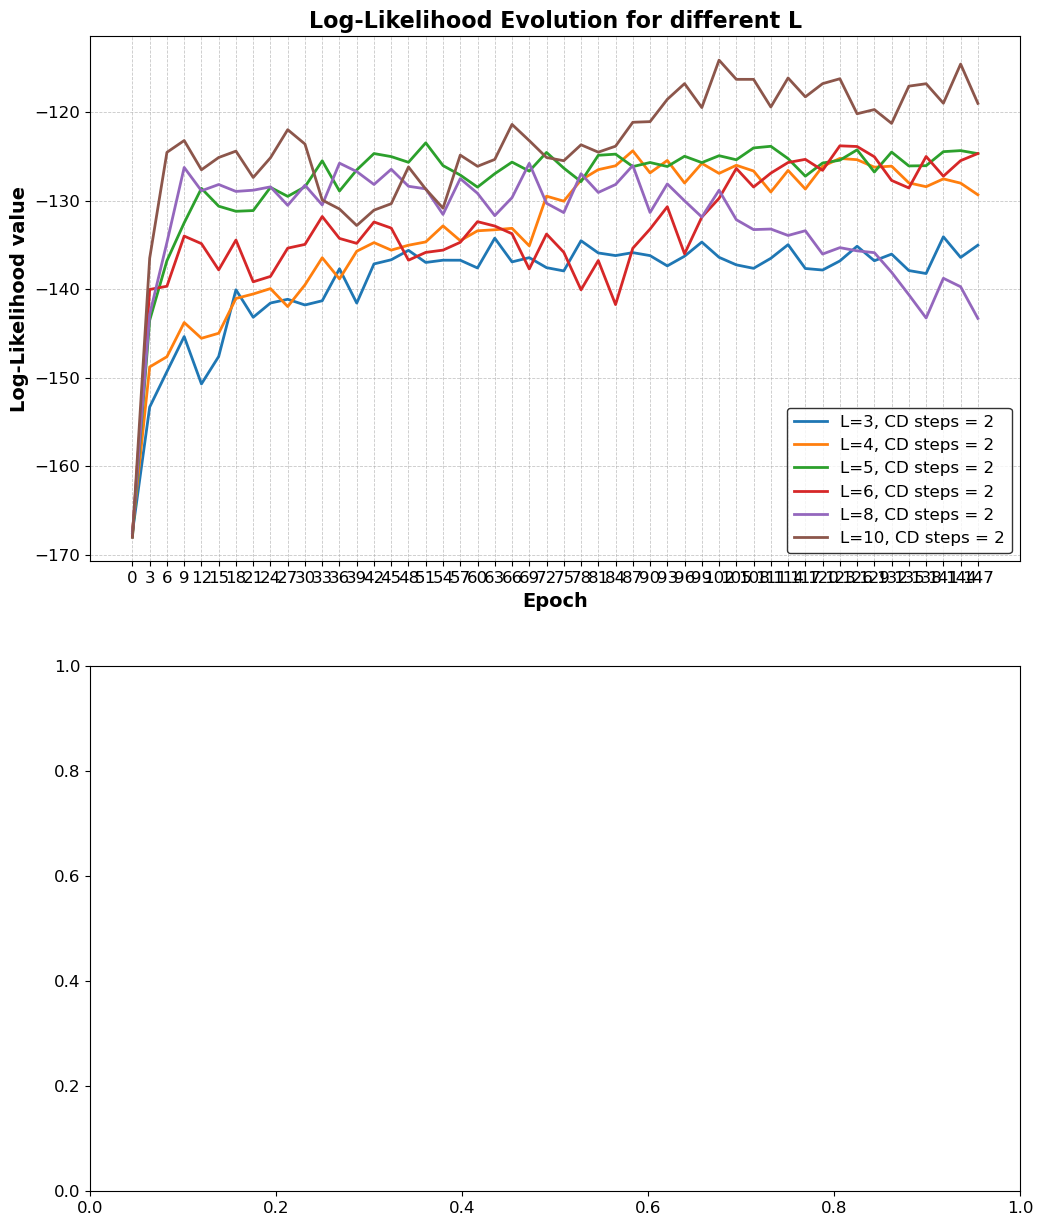

ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

In [28]:
# drawing graphs
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,15))
    
for i,log_like in enumerate(log_like_L): # fixed CD steps=2
    ax1.plot(num_epo, log_like, label=f'L={L_v[i]}, CD steps = 2',linewidth=2, markersize=4, markerfacecolor='black', markeredgewidth=1)
    ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Log-Likelihood value', fontsize=14, fontweight='bold')
    ax1.set_title('Log-Likelihood Evolution for different L', fontsize=16, fontweight='bold')
    ax1.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    ax1.set_xticks(num_epo)
    ax1.legend(fontsize=12, loc='lower right', frameon=True, edgecolor='black')
plt.show()

for i,log_like in enumerate(log_like_cd): # fixed l=3
    ax2.plot(num_epo, log_like, label=f'L={L_v[0]}, CD steps ={Nt_v[i]}',marker='o',linewidth=2, markersize=4, markerfacecolor='black', markeredgewidth=1)
    ax2.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Log-Likelihood value', fontsize=14, fontweight='bold')
    ax2.set_title('Log-Likelihood evolution for different CD steps', fontsize=16, fontweight='bold')
    ax2.set_xticks(num_epo)
    ax2.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    ax2.legend(fontsize=12, loc='lower right', frameon=True, edgecolor='black')
        

## Likelihood dependance on number of visible variables and CD steps  

Now we want to compare the likelihood values after the transient, in the last epochs of training, varying the parameters L and Nt. We previously observed that the likelihood appers to be quite stable after a certain number of epochs, but this needs to be verified more rigorously considering more iterations for each likelihhod estimation (10 for computational feasability), and taking their average and standard deviation. We focus on the last 10 epochs and, after verifying the stability of the likelihood, we compare their average values for the different number of visible variables and CD steps considered.       

In [17]:
# Log-likelyhood after transient for different L and fixed CD steps = 2: stability check and mean; mean comparison for different L

log_like_L=[]
log_like_L_std=[]
Nepoch=150
num_epo=np.arange(Nepoch-10,Nepoch,1)

for L in L_v:
    Nt=2
    a_all = np.load(f"WEIGHTS/a_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
    print(f'a_all L={L}, Nt={Nt}')  ## 1 peso per visible per epoch
    b_all= np.load(f"WEIGHTS/b_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
    print(f'b_all L={L}, Nt={Nt}')  ## 1 peso per hidden per epoch
    w_all=np.load(f"WEIGHTS/w_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
    print(f'w_all L={L}, Nt={Nt}') ## matrice visible*hidden per epoch   
            
    log_like=[]
    log_like_std=[]
    for i in range(Nepoch-10,Nepoch,1):
        print(f'Epoch n.{i}')
        ll_iter= []
        for iter in range(10): # to determine the loglike at each epoch we run the calculation 10 times and compute the average, to reduce randomness
            ll=compute_log_likelihood(w_all[i], a_all[i], b_all[i], data)
            ll_iter.append(ll)
        ll_mean= np.array(ll_iter).mean()
        ll_std= np.array(ll_iter).std()
        log_like.append(ll_mean)
        log_like_std.append(ll_std)
        print('Log-likelihood=',ll_mean,"+-",ll_std)
    log_like_L.append(log_like)
    log_like_L_std.append(log_like_std)
        

a_all L=3, Nt=2
b_all L=3, Nt=2
w_all L=3, Nt=2
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1259.76it/s]


Log-likelihood= -135.33417648347438 +- 0.4948436913465755
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1140.92it/s]


Log-likelihood= -134.8111327991385 +- 0.7519264151407518
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1185.13it/s]


Log-likelihood= -135.55996648476102 +- 0.4509732611999631
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1220.98it/s]


Log-likelihood= -135.3511763225206 +- 0.547801735890055
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1231.27it/s]


Log-likelihood= -135.90257631379617 +- 0.728230882196492
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1194.41it/s]


Log-likelihood= -136.76855143709196 +- 0.47586230560254345
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1279.10it/s]


Log-likelihood= -135.16244862200264 +- 0.5562445680022283
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1257.01it/s]


Log-likelihood= -135.29951070916115 +- 0.6054118397588848
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1167.63it/s]


Log-likelihood= -137.856631852215 +- 0.3441585016734641
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:04<00:00, 1286.59it/s]


Log-likelihood= -136.16619959293686 +- 0.25801107424517805
a_all L=4, Nt=2
b_all L=4, Nt=2
w_all L=4, Nt=2
Epoch n.140


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 513.36it/s]


Log-likelihood= -127.23964660500101 +- 0.6780543748242523
Epoch n.141


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 664.22it/s]


Log-likelihood= -127.51342276154364 +- 0.6509824597578027
Epoch n.142


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 660.13it/s]


Log-likelihood= -127.10669977917291 +- 0.5055897364897357
Epoch n.143


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 664.17it/s]


Log-likelihood= -127.87576526185676 +- 0.4787348963725224
Epoch n.144


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 668.49it/s]


Log-likelihood= -128.63018612941715 +- 0.519124372826951
Epoch n.145


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 658.09it/s]


Log-likelihood= -126.13121638301577 +- 0.32314326017105055
Epoch n.146


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 630.02it/s]


Log-likelihood= -128.37572819065633 +- 0.5815404561838426
Epoch n.147


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 630.22it/s]


Log-likelihood= -127.59672423564625 +- 0.3357670414481326
Epoch n.148


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 628.76it/s]


Log-likelihood= -127.85731339124989 +- 0.60759003302781
Epoch n.149


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 522.57it/s]


Log-likelihood= -127.24332584476846 +- 0.3837833880827182
a_all L=5, Nt=2
b_all L=5, Nt=2
w_all L=5, Nt=2
Epoch n.140


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:19<00:00, 286.59it/s]


Log-likelihood= -124.89476238745674 +- 0.9758199745947126
Epoch n.141


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:16<00:00, 324.57it/s]


Log-likelihood= -124.32258789311607 +- 0.600548972734193
Epoch n.142


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 641.41it/s]


Log-likelihood= -125.20089106503936 +- 0.6650164555437056
Epoch n.143


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:11<00:00, 496.01it/s]


Log-likelihood= -124.39628785756847 +- 0.5295998619426238
Epoch n.144


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 633.18it/s]


Log-likelihood= -124.21529083572823 +- 0.6846724798821712
Epoch n.145


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 640.20it/s]


Log-likelihood= -124.71925130957898 +- 0.6167279671393802
Epoch n.146


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 521.09it/s]


Log-likelihood= -124.59398138047318 +- 0.5755982318103808
Epoch n.147


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 637.73it/s]


Log-likelihood= -124.75019284466148 +- 0.501963749973891
Epoch n.148


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:08<00:00, 642.09it/s]


Log-likelihood= -124.58670012040932 +- 0.6344227892486787
Epoch n.149


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:10<00:00, 522.32it/s]


Log-likelihood= -126.353581685533 +- 0.6850705981884185
a_all L=6, Nt=2
b_all L=6, Nt=2
w_all L=6, Nt=2
Epoch n.140


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:19<00:00, 283.45it/s]


Log-likelihood= -124.39803732334796 +- 0.5754579471967136
Epoch n.141


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 315.32it/s]


Log-likelihood= -128.07955933051826 +- 0.3888809271906497
Epoch n.142


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 322.19it/s]


Log-likelihood= -126.26470575733603 +- 0.5187534766411706
Epoch n.143


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 292.17it/s]


Log-likelihood= -125.09584782778013 +- 0.5254182921438733
Epoch n.144


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:17<00:00, 321.92it/s]


Log-likelihood= -125.1264102145808 +- 0.5315586332479377
Epoch n.145


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:16<00:00, 326.19it/s]


Log-likelihood= -122.57487770281391 +- 0.904060831077091
Epoch n.146


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 290.48it/s]


Log-likelihood= -125.33736516050458 +- 0.5439818076971923
Epoch n.147


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:18<00:00, 293.44it/s]


Log-likelihood= -124.25358464764872 +- 0.5476136563096112
Epoch n.148


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:16<00:00, 336.04it/s]


Log-likelihood= -123.90844003512714 +- 0.4056092130889154
Epoch n.149


Computing log-likelihood: 100%|████████████████████████████████████████████████████| 5498/5498 [00:16<00:00, 327.66it/s]


Log-likelihood= -125.34595677910254 +- 0.7057755641162581
a_all L=8, Nt=2
b_all L=8, Nt=2
w_all L=8, Nt=2
Epoch n.140


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.15it/s]


Log-likelihood= -138.8940384882829 +- 0.6695564998307214
Epoch n.141


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 78.37it/s]


Log-likelihood= -138.8846233625182 +- 0.5734429837321443
Epoch n.142


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.96it/s]


Log-likelihood= -141.19081979456698 +- 0.40445018925136705
Epoch n.143


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:11<00:00, 77.43it/s]


Log-likelihood= -142.0026786300512 +- 0.7902159243919353
Epoch n.144


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.88it/s]


Log-likelihood= -139.93224318546316 +- 0.5682470997883244
Epoch n.145


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:09<00:00, 79.38it/s]


Log-likelihood= -143.31943112793687 +- 0.39284761572730864
Epoch n.146


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:08<00:00, 79.90it/s]


Log-likelihood= -142.93490990751363 +- 0.6556731291415835
Epoch n.147


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.81it/s]


Log-likelihood= -142.83249761388294 +- 0.4144386309838914
Epoch n.148


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:10<00:00, 77.91it/s]


Log-likelihood= -144.50049937518668 +- 0.4488331629640661
Epoch n.149


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [01:13<00:00, 74.72it/s]


Log-likelihood= -143.95647410022974 +- 0.6227667792952782
a_all L=10, Nt=2
b_all L=10, Nt=2
w_all L=10, Nt=2
Epoch n.140


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:44<00:00, 19.29it/s]


Log-likelihood= -120.98272949543063 +- 0.1880402209943159
Epoch n.141


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:59<00:00, 18.34it/s]


Log-likelihood= -119.06022603199169 +- 0.3886766717074701
Epoch n.142


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:41<00:00, 19.52it/s]


Log-likelihood= -118.15374164821438 +- 0.44014342644319515
Epoch n.143


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:33<00:00, 20.10it/s]


Log-likelihood= -120.63752887443452 +- 0.37117820128720863
Epoch n.144


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:34<00:00, 20.06it/s]


Log-likelihood= -115.27407393736273 +- 0.5426310855937532
Epoch n.145


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:53<00:00, 18.72it/s]


Log-likelihood= -118.33354007929377 +- 0.2893632765113282
Epoch n.146


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:41<00:00, 19.56it/s]


Log-likelihood= -118.2082683436015 +- 0.5958565634503485
Epoch n.147


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:51<00:00, 18.88it/s]


Log-likelihood= -119.16769683870943 +- 0.4292029640536674
Epoch n.148


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:50<00:00, 18.92it/s]


Log-likelihood= -115.77222552770385 +- 0.2773327479113979
Epoch n.149


Computing log-likelihood: 100%|█████████████████████████████████████████████████████| 5498/5498 [04:55<00:00, 18.58it/s]

Log-likelihood= -114.99729793520255 +- 0.7080737294347231


## CELLA PER SALVARE IL KERNEL

In [29]:
import dill
dill.dump_session('save_ll_1.7.db')
#import dill
#dill.load_session('save_ll.db_1.7')
#

In [22]:
# Log-likelyhood after transient for different CD steps and fixed L = 3: stability check and mean; mean comparison for different CD steps

log_like_cd=[]
log_like_cd_std=[]
Nepoch=150
num_epo=np.arange(Nepoch-10,Nepoch,1)

for L in L_v:
    if L==3:
        for Nt in Nt_v:
            a_all = np.load(f"WEIGHTS/a_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
            print(f'a_all L={L}, Nt={Nt}')  ## 1 peso per visible per epoch
            b_all= np.load(f"WEIGHTS/b_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
            print(f'b_all L={L}, Nt={Nt}')  ## 1 peso per hidden per epoch
            w_all=np.load(f"WEIGHTS/w_RBM_MNIST3_L{L}_Nt{Nt}_RMSprop-0.05-0.05_Ep150_reg0.001_20250317.npy", allow_pickle=True)
            print(f'w_all L={L}, Nt={Nt}') ## matrice visible*hidden per epoch   
                    
            log_like=[]
            log_like_std=[]
            Nepoch=150
            for i in range(Nepoch-10,Nepoch,1):
                print(f'Epoch n.{i}')
                ll_iter=[]
                mean=[]
                for iter in range(10): # to determine the loglike at each epoch we run the calculation 10 times and compute the average, to reduce randomness
                    ll=compute_log_likelihood(w_all[i], a_all[i], b_all[i], data)
                    ll_iter.append(ll)
                ll_mean= np.array(ll_iter).mean()
                ll_std= np.array(ll_iter).std()
                log_like.append(ll_mean)
                log_like_std.append(ll_std)
                print('Log-likelihood=',ll_mean,"+-",ll_std)
            log_like_cd.append(log_like)
            log_like_cd_std.append(log_like_std)
                

a_all L=3, Nt=2
b_all L=3, Nt=2
w_all L=3, Nt=2
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2303.36it/s]


Log-likelihood= -135.40244199882693 +- 0.4064576716831954
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2281.73it/s]


Log-likelihood= -134.80174518824106 +- 0.6544495331297595
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2255.27it/s]


Log-likelihood= -135.4733447721828 +- 0.4727529126773889
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2281.40it/s]


Log-likelihood= -134.85709953691213 +- 0.5561732850054889
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2287.75it/s]


Log-likelihood= -135.60779506409935 +- 0.38213269719854126
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2302.47it/s]


Log-likelihood= -136.66377353849435 +- 0.7581315063921562
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2318.56it/s]


Log-likelihood= -135.32058149727166 +- 0.2423803120777691
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2088.95it/s]


Log-likelihood= -135.46887302374594 +- 0.5678899520697064
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2185.31it/s]


Log-likelihood= -137.95932993407374 +- 0.4370521579879841
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2264.38it/s]


Log-likelihood= -136.34938393386227 +- 0.3984022302331581
a_all L=3, Nt=4
b_all L=3, Nt=4
w_all L=3, Nt=4
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2145.98it/s]


Log-likelihood= -131.78400472104974 +- 0.6156035629335075
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2046.90it/s]


Log-likelihood= -133.4510570424571 +- 0.7007948806647603
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2128.24it/s]


Log-likelihood= -131.65811079246814 +- 0.5635793653271923
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2194.06it/s]


Log-likelihood= -132.15154309424784 +- 0.560565735000031
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2213.10it/s]


Log-likelihood= -132.04595727772278 +- 0.6755670677629372
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2287.43it/s]


Log-likelihood= -132.60066211388505 +- 0.6671162489332465
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2236.96it/s]


Log-likelihood= -131.97316505605727 +- 0.6878004506596289
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2116.09it/s]


Log-likelihood= -131.5429920280286 +- 0.5377688847156716
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2195.19it/s]


Log-likelihood= -131.48110043235027 +- 0.6864442451894349
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2124.71it/s]


Log-likelihood= -131.6920525186129 +- 0.7851726696602334
a_all L=3, Nt=6
b_all L=3, Nt=6
w_all L=3, Nt=6
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2303.93it/s]


Log-likelihood= -138.5189379465333 +- 0.588272834139861
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2231.17it/s]


Log-likelihood= -138.0830687221584 +- 0.533357643559949
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2112.52it/s]


Log-likelihood= -136.69706982423364 +- 0.4469185615013901
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2181.67it/s]


Log-likelihood= -139.25442254791417 +- 0.43331996389215605
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2297.09it/s]


Log-likelihood= -137.522518426016 +- 0.41561270607493656
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3205.86it/s]


Log-likelihood= -139.0266563235406 +- 0.560888616334427
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2300.66it/s]


Log-likelihood= -137.09725928832418 +- 0.5871874193054396
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2192.89it/s]


Log-likelihood= -138.87441175683392 +- 0.556122196952543
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2216.75it/s]


Log-likelihood= -137.2204115241542 +- 0.3870065509106904
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2222.09it/s]


Log-likelihood= -137.1386697223408 +- 0.41515645049600175
a_all L=3, Nt=8
b_all L=3, Nt=8
w_all L=3, Nt=8
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2211.36it/s]


Log-likelihood= -131.93444690763366 +- 0.5992888370884695
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2238.25it/s]


Log-likelihood= -131.26384222353695 +- 0.633165671183006
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2215.65it/s]


Log-likelihood= -131.83929376012918 +- 0.6172394313356687
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2121.61it/s]


Log-likelihood= -132.75838543082148 +- 0.6102940064162099
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 2961.52it/s]


Log-likelihood= -131.50124926168507 +- 0.5949768092231003
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2166.11it/s]


Log-likelihood= -131.70532187613148 +- 0.4150116301992774
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2237.69it/s]


Log-likelihood= -131.39400500651692 +- 0.5506826404248658
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2271.43it/s]


Log-likelihood= -131.9267508834783 +- 0.6128364020183464
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2297.70it/s]


Log-likelihood= -132.07714446105746 +- 0.6500349131992584
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2209.74it/s]


Log-likelihood= -132.65609932041366 +- 0.555598822602165
a_all L=3, Nt=10
b_all L=3, Nt=10
w_all L=3, Nt=10
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2269.61it/s]


Log-likelihood= -139.22652463607128 +- 0.4957176355423664
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2283.60it/s]


Log-likelihood= -138.2416056269301 +- 0.4765155792163485
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3365.60it/s]


Log-likelihood= -138.19518722014908 +- 0.6447341640592643
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2322.81it/s]


Log-likelihood= -138.79636511472617 +- 0.47976882421021505
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2242.59it/s]


Log-likelihood= -138.86111333115795 +- 0.4910005354421933
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2210.69it/s]


Log-likelihood= -139.37913916431813 +- 0.6591393618671353
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2244.12it/s]


Log-likelihood= -137.25599268025408 +- 0.48488594644730243
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2181.36it/s]


Log-likelihood= -137.32012826392247 +- 0.5331333744545672
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2192.51it/s]


Log-likelihood= -138.8454413367235 +- 0.24931820809070573
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2104.26it/s]


Log-likelihood= -139.7254582172481 +- 0.45059376677110324
a_all L=3, Nt=15
b_all L=3, Nt=15
w_all L=3, Nt=15
Epoch n.140


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2290.55it/s]


Log-likelihood= -134.95994553501606 +- 0.4446400687830309
Epoch n.141


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2248.70it/s]


Log-likelihood= -134.5258668775715 +- 0.8428762802819025
Epoch n.142


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2252.34it/s]


Log-likelihood= -134.39313539889125 +- 0.6601746132077289
Epoch n.143


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2294.19it/s]


Log-likelihood= -134.80374006767016 +- 0.7263023012433573
Epoch n.144


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2352.10it/s]


Log-likelihood= -134.62408650413028 +- 0.71548688680001
Epoch n.145


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:01<00:00, 3120.23it/s]


Log-likelihood= -135.23556137915062 +- 0.5754182086565504
Epoch n.146


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2221.82it/s]


Log-likelihood= -135.3570455709304 +- 0.5345471318252437
Epoch n.147


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2256.19it/s]


Log-likelihood= -133.8319397373477 +- 0.5191095584380684
Epoch n.148


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2213.68it/s]


Log-likelihood= -134.81752609460844 +- 0.6343818886318692
Epoch n.149


Computing log-likelihood: 100%|███████████████████████████████████████████████████| 5498/5498 [00:02<00:00, 2298.82it/s]

Log-likelihood= -134.50114583157932 +- 0.6634738584173402


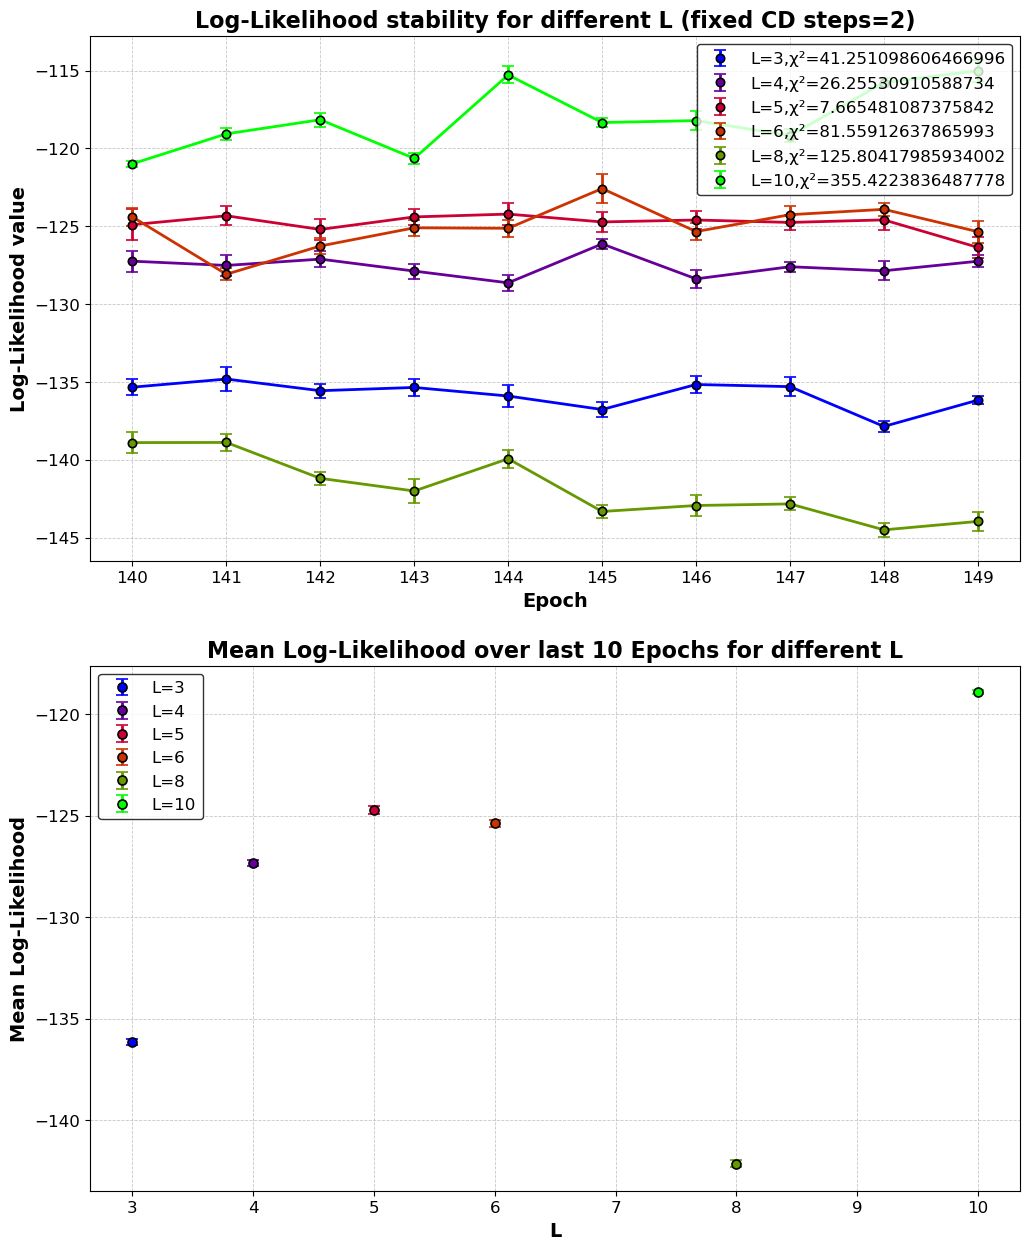

In [21]:
# plots of log-likelihood of last 10 epochs and their mean

# variable L, fixed CD steps
colors = plt.cm.brg(np.linspace(0, 1, len(log_like_L)))
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,15))
num_epo=np.arange(Nepoch-10,Nepoch,1)

for i, log_like in enumerate(log_like_L):
    weights = 1 / np.array(log_like_L_std[i])**2  
    weighted_avg = np.average(log_like, weights=weights)  # weighted average of log-likelihoods
    weighted_error = np.sqrt(1 / np.sum(weights)) # error of weighted average
    chi = np.sum(((log_like - weighted_avg*np.ones(10))/log_like_L_std[i]) ** 2)
    
    ax1.errorbar(num_epo,log_like,yerr=log_like_L_std[i],fmt='o',color=colors[i],label=f'L={L_v[i]},χ²={chi}',linewidth=2, markersize=6,capsize=4, capthick=1,markerfacecolor=colors[i], markeredgecolor='black', markeredgewidth=1.2)
    ax1.plot(num_epo, log_like, color=colors[i], linewidth=2)
    
    ax2.errorbar(L_v[i],weighted_avg,yerr=weighted_error,fmt='o',color=colors[i],label=f'L={L_v[i]}',linewidth=2,markersize=6.5,capsize=4, capthick=1,markerfacecolor=colors[i], markeredgecolor='black',markeredgewidth=1.2 )
    #ax1.plot(num_epo,np.ones(10)*weighted_avg,linestyle='--',color=colors[i])

ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Log-Likelihood value', fontsize=14, fontweight='bold')
ax1.set_title('Log-Likelihood stability for different L (fixed CD steps=2)', fontsize=16, fontweight='bold')
ax1.set_xticks(num_epo)
ax1.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax1.legend(fontsize=12, loc='best', frameon=True, edgecolor='black')

ax2.set_xlabel('L', fontsize=14, fontweight='bold')
ax2.set_ylabel('Mean Log-Likelihood', fontsize=14, fontweight='bold')
ax2.set_title('Mean Log-Likelihood over last 10 Epochs for different L', fontsize=16, fontweight='bold')
ax2.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax2.legend(fontsize=12, loc='best', frameon=True, edgecolor='black')

plt.show()

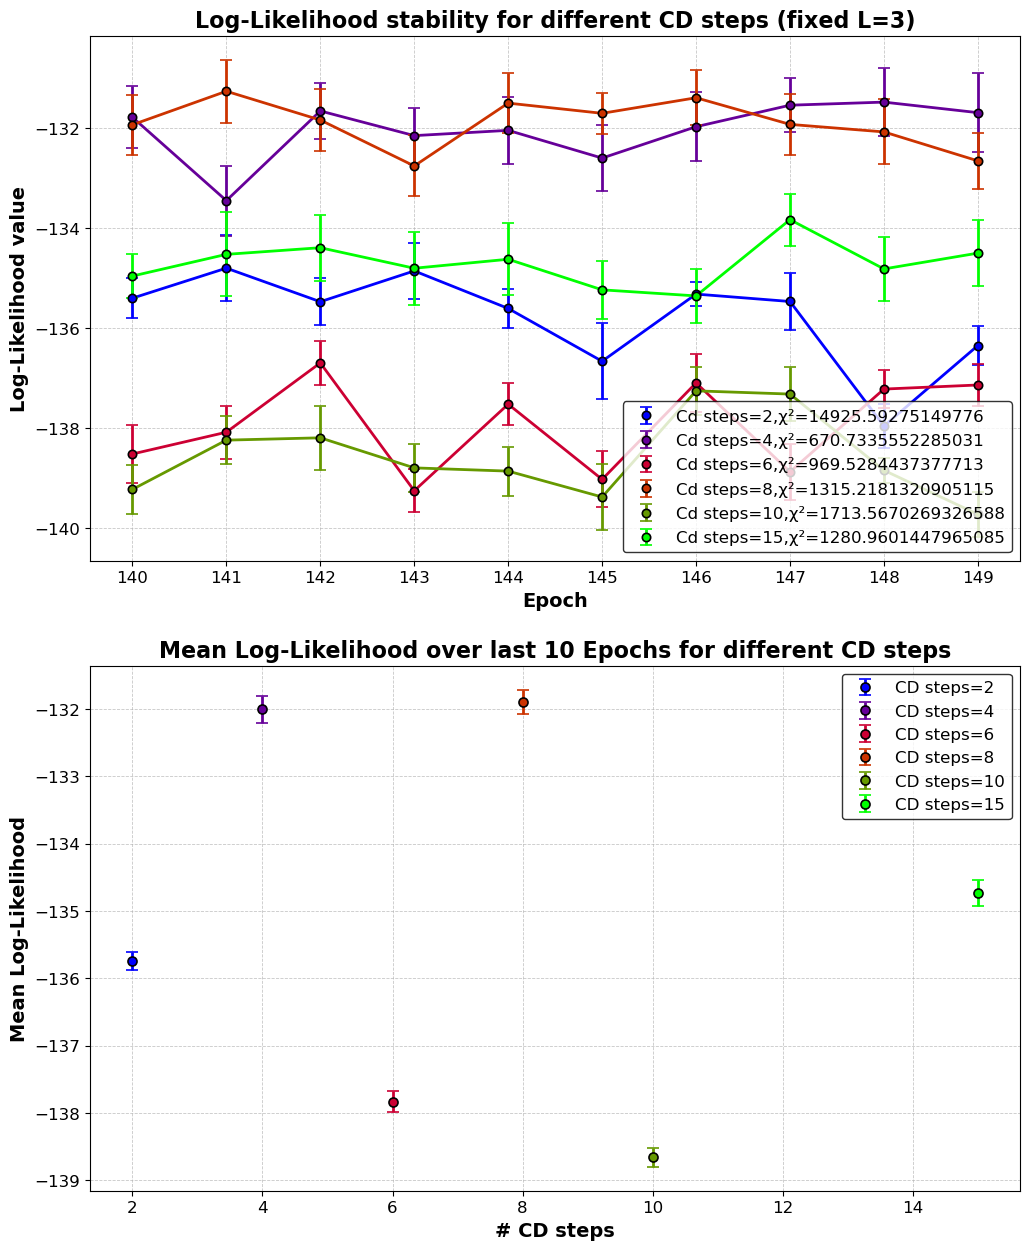

In [23]:
# variable CD steps, fixed L
colors = plt.cm.brg(np.linspace(0, 1, len(log_like_cd)))
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,15))

for i, log_like in enumerate(log_like_cd):
    chi = np.sum(((log_like - weighted_avg*np.ones(10))/log_like_L_std[i]) ** 2)
    weights = 1 / np.array(log_like_cd_std[i])**2  
    weighted_avg = np.average(log_like, weights=weights)  # weighted average of log-likelihoods of last 10 epochs
    weighted_error = np.sqrt(1 / np.sum(weights)) # error of weighted average 
    
    ax1.errorbar(num_epo,log_like,yerr=log_like_cd_std[i],fmt='o',color=colors[i],label=f'Cd steps={Nt_v[i]},χ²={chi}',linewidth=2, markersize=6,capsize=4, capthick=1,markerfacecolor=colors[i], markeredgecolor='black', markeredgewidth=1.2)
    ax1.plot(num_epo, log_like, color=colors[i], linewidth=2)
    
    ax2.errorbar(Nt_v[i],weighted_avg,yerr=weighted_error,fmt='o',color=colors[i],label=f'CD steps={Nt_v[i]}',linewidth=2,markersize=6.5,capsize=4, capthick=1,markerfacecolor=colors[i], markeredgecolor='black',markeredgewidth=1.2 )
    #ax1.plot(num_epo,np.ones(10)*weighted_avg,linestyle='--',color=colors[i])

ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Log-Likelihood value', fontsize=14, fontweight='bold')
ax1.set_title('Log-Likelihood stability for different CD steps (fixed L=3)', fontsize=16, fontweight='bold')
ax1.set_xticks(num_epo)
ax1.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax1.legend(fontsize=12, loc='best', frameon=True, edgecolor='black')

ax2.set_xlabel('# CD steps', fontsize=14, fontweight='bold')
ax2.set_ylabel('Mean Log-Likelihood', fontsize=14, fontweight='bold')
ax2.set_title('Mean Log-Likelihood over last 10 Epochs for different CD steps', fontsize=16, fontweight='bold')
ax2.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax2.legend(fontsize=12, loc='best', frameon=True, edgecolor='black')

plt.show()